# Expérience 5.4 : Denoising with a total generalized variation prior

Dans cette expérience, on considère un problème de débruitage d'une image observée $y \sim \textit{N}(x,\sigma^2I)$ avec $\sigma >0$ et la loi à priori :
$$p(x|\theta^1,\theta^2) = \frac{1}{Z(\theta^1,\theta^2)} exp\{-TGV_{\theta^1,\theta^2}^2(x) - \epsilon ||x||^2_2\}$$
Avec $\epsilon>0$ et $TGV_{\theta^1,\theta^2}^2(x)$ est une généralisation du second ordre de la régularisation TV, et est définie pour tout $(\theta^1,\theta^2) \in [0,+\infty)^2$ et $x \in \mathbb{R}^d$ par :
$$TGV_{\theta^1,\theta^2}^2(x) = \min\limits_{r \in \mathbb{R}^{2d}} \theta^1||r||_{1,2} + \theta^2 ||J(\Delta x-r)||_{1,Frob}$$
Avec $ \Delta = (\Delta^v,\Delta^h)$  l'opérateur gradient qui calcule les différences horizontales et verticales du premier ordre entre les pixels, et $J$ l'opérateur qui calcule le jacobien du gradient de l'image afin d'obtenir des informations du second ordre sur l'image.

Le problème de débruitage consiste ainsi à chercher l'image  $\hat{x}_{MAP}$ qui résout le problème :

$$argmin_{x \in \mathbb{R}^d} \frac{1}{2\sigma^2} ||y-x||^2_2 + TGV^2_{\theta^1,\theta^2}(x) + \epsilon ||x||^2_2 $$

L'utilisation de la régularisation TGV nécessite de bien choisir les paramètres $(\theta^1,\theta^2)$. La première expérience qu'on va reproduire est celle de la figure 14 de l'article où on montre les différentes images débruités qu'on obtient en fonction des paramètres $(\theta^1,\theta^2)$.

L'implémentation de l'algorithme de débruitage TGV est basée sur le solveur primal-dual 3.1 présenté dans [L. Condat, "A primal-dual splitting method for convex optimization involving Lipschitzian, proximable and linear composite terms] et [Laurent Condat. Matlab code for total generalized variation denoising, 2016], ainsi on suit les étapes suivantes :



> On choisit les paramètres proximaux $\tau$ et $\tau'$, la suite des paramètres de relaxation $(\rho_n)_n$ et les valeurs initiales des variables primales $x$ et $r$ et de la variable duale u. pour $n \in \{0,...,Nbiter\}$ :

1.   $\tilde{x}_{n+1} = prox_{\tau F_x}(x_n - \tau \Delta^*(J^*(u_n))$
2.   $\tilde{r}_{n+1} = prox_{\tau F_r}(r_n + \tau J^*(u_n))$
3.   $\tilde{u}_{n+1} = prox_{\tau' G^*}(u_n - \tau' J(\Delta(2\tilde{x}_{n+1}-x_n)-2\tilde{r}_{n+1}-r_n)$
4.   $(x_{n+1},r_{n+1},u_{n+1}) = (1-\rho_n) * (x_{n},r_{n},u_{n}) + \rho_n * (\tilde{x}_{n+1},\tilde{r}_{n+1},\tilde{u}_{n+1}) $

Avec  :


*   $F_x(x) = \frac{1}{2\sigma^2} ||y-x||^2_2 + \epsilon ||x||^2_2 $ donc $prox_{\tau F_x}(x) = \frac{\sigma^2 x + \tau y}{\sigma^2 + \tau + 2\epsilon \sigma^2 \tau}$
*   $F_r(r) = \theta^1 ||r||_{1,2}$ donc $prox_{\tau F_r}(r) = r - \frac{r}{max(||\frac{r}{\tau \theta^1}||_{1,2}^{*},1)}$
* $G(u) = \theta^2||u||_{1,Frob}$ donc $prox_{\tau' G^*}(u) = \frac{u}{max(||\frac{u}{\theta^2}||_{1,Frob}^*,1)}$
* $L(x,r) = J(\Delta(x)-r)$

(Les détails des calculs sont présentés dans le rapport)

(Les expressions des opérateurs $J^*, \Delta^*, ||||_{1,2}^*, et ||||_{1,Frob}^*$ sont présentées dans le code du solveur [Laurent Condat. Matlab code for total generalized variation denoising, 2016])









In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
import os
from scipy import ndimage
from math import sqrt
from skimage.measure import compare_psnr
from skimage.metrics import peak_signal_noise_ratio
import time
import scipy
import pickle
from mpl_toolkits import mplot3d
if os.path.isdir('im_noise') == False :
    os.mkdir('im_noise')
if os.path.isdir('im_denoise') == False :
    os.mkdir('im_denoised')

In [3]:
#On définit la version "vecteur" dans la fonction puissance qui retourne un array de même dimension que celui en entrée tq output[i,j] = input[i,j]**n pour tout i,j
def puissance(a,n) :
  return a**n
puissance = np.vectorize(puissance)

#On définit la version "vecteur" dans la fonction max qui retourne un array de même dimension que celui en entrée tq output[i,j] = max(input1[i,j],input2) pour tout i,j
def max_vectorized(x,y) :
  return max(x,y)
max_vectorized = np.vectorize(max_vectorized)


# la fonction $prox_{\tau F_r}$
def prox_tau_fr(r,tau,theta1) : 
    H,W,n = np.shape(r)
    res = np.zeros((H,W,n))
    a = max_vectorized(np.sqrt(np.sum(puissance(r,2),2))/(tau*theta1),1)
    for i in range(n) :
        res[:,:,i] = r[:,:,i]-r[:,:,i]/a
    return res

# la fonction $prox_{\tau' G*}$  
def prox_g_conj(u,theta2) : 
    H,W,n = np.shape(u)
    res = np.zeros((H,W,n))
    a = max_vectorized(np.sqrt(np.sum(puissance(u,2),2))/theta2,1)
    for i in range(n) :
        res[:,:,i] = u[:,:,i]/a 
    return res


# La fonction du débruitage TGV : 
def TGVdenoising(y,theta1,theta2,sigma,Nbiter) :
    rho = 1.99
    tau = 0.1*(sigma**2)
    tau_prime = 1/tau/72 
    epsilon = 1e-10
    nl,nc=np.shape(y)
 
  #Définition des opérateurs \Delta, J et leurs conjugués, et définition de la fonction prox_{tau F_x}
    opD = lambda x : np.stack((np.block([[np.diff(x,1,axis=0)],[np.zeros((1,nc))]]),np.block([np.diff(x,1,axis=1),np.zeros((nl,1))])),axis=-1)
    opDadj = lambda u :  np.block([[-u[0,:,0].reshape(1,-1)],[-np.diff(u[0:-1,:,0],1,axis=0)],[u[-2,:,0].reshape(1,-1)]]) + np.block([-u[:,0,1].reshape(-1,1),-np.diff(u[:,0:-1,1],1,axis=1),u[:,-2,1].reshape(-1,1)])
    opJ = lambda r :  np.stack((np.block([[r[0,:,0].reshape(1,-1)],[np.diff(r[:,:,0],1,axis=0)]]),np.block([np.diff(r[:,:,0],1,axis=1),np.zeros((nl,1))]),np.block([r[:,0,1].reshape(-1,1),np.diff(r[:,:,1],1,axis=1)]),np.block([[np.diff(r[:,:,1],1,axis=0)],[np.zeros((1,nc))]])),axis=-1)
    opJadj = lambda u : np.stack((np.block([[-np.diff(u[:,:,0],1,axis=0)],[u[-1,:,0].reshape(1,-1)]]) - np.block([u[:,0,1].reshape(-1,1),np.diff(u[:,:,1],1,axis=1)]),np.block([-np.diff(u[:,:,2],1,axis=1),u[:,-1,2].reshape(-1,1)]) - np.block([[u[0,:,3].reshape(1,-1)],[np.diff(u[:,:,3],1,axis=0)]])),axis=-1) 
    prox_tau_fx = lambda x : ((sigma**2)*x+tau*y)/(sigma**2+tau+2*tau*epsilon*(sigma**2))



    x2 = y 
    r2 = np.zeros((nl,nc,2))
    u2 = np.zeros((nl,nc,4))
  #Ligne à décommenter si on veut tester la convergence de l'algorithme
    #cost = norm(x2-y,'fro')/(2*(sigma**2)) + theta1*np.sum(np.sum(np.sqrt(np.sum(puissance(r2,2),2))))+theta2*np.sum(np.sum(np.sqrt(np.sum(puissance(opJ(opD(x2)-r2),2),2))))
    #start = time.time()

    for i in range(Nbiter):
        tmp = tau*opJadj(u2)
        x = prox_tau_fx(x2-opDadj(tmp))
        r = prox_tau_fr(r2+tmp,tau,theta1)
        u = prox_g_conj(u2+tau_prime*opJ(opD(2*x-x2)-(2*r-r2)),theta2)
        x2 = x2+rho*(x-x2)
        r2 = r2+rho*(r-r2)
        u2 = u2+rho*(u-u2)
    #Lignes à décommenter si on veut tester la convergence de l'algorithme
        #cost = norm(x-y,'fro')/(2*(sigma**2)) + theta1*np.sum(np.sum(np.sqrt(np.sum(puissance(r,2),2))))+theta2*np.sum(np.sum(np.sqrt(np.sum(puissance(opJ(opD(x)-r),2),2))))
        #if i%25 == 0 :
            #print("iteration : ",i," cost : ",cost," time : ",time.time()-start)
    return x

# Test de l'algorithme de débruitage TGV avec différentes valeurs de $\theta^1, \theta^2$

On reproduit les résultats présentés dans la figure 14. Pour ce faire, on choisit les valeurs de $\theta^1$ dans la liste [1,10,100], et celles de $\theta^2$ dans [1.5,15,150]. On teste l'algorithme pour  une image y telle que le ratio SNR = 5.6 db. L'image originale est l'image test $\textit{parrot}$.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


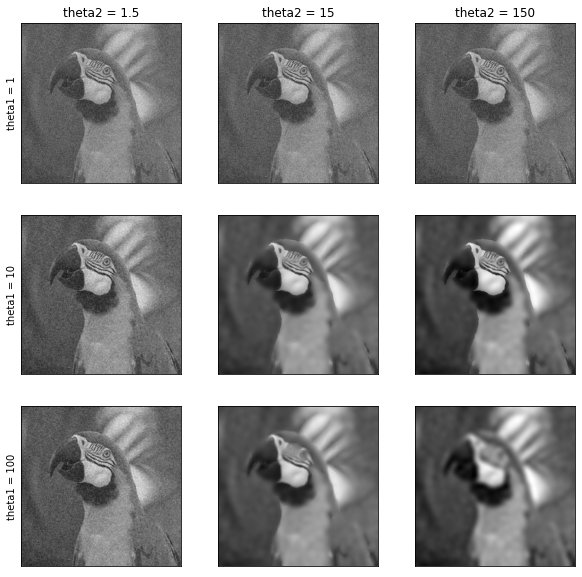

In [0]:
Nbiter= 400
theta1_list = [1,10,100]
theta2_list = [1.5,15,150]

fig = plt.figure(figsize=(10, 10))
columns = 3
rows = 3
i = 1
ax = []
psnr = []

im = 'parrotgray.png'
real  = plt.imread('./im/'+im) 
SNR = 5.6
sigma = 10**(-SNR/10)* ndimage.mean(real)
nr,nc = real.shape
y = real+np.random.randn(nr,nc)*sigma
plt.imsave('./im_noise/parrot56.png',y,cmap='gray')
np.save('./parrot56.npy',y)

for theta1 in theta1_list :
  for theta2 in theta2_list :
    x = TGVdenoising(y,theta1,theta2,sigma,Nbiter)
    ax.append( fig.add_subplot(rows, columns, i) )
    psnr.append(peak_signal_noise_ratio(real,x))
    if i in [1,4,7] :
      ax[-1].set_ylabel('theta1 = '+ str(theta1))
    if i in [1,2,3] :
      ax[-1].set_title("theta2 = "+ str(theta2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(x,cmap='gray')
    i += 1

Dans la cellule code ci-dessous, on calcule la valeur du psnr pour différentes valeurs de $\theta^1,\theta^2$. On choisit les valeurs de $\theta^1$ dans np.exp(np.log(10)*np.linspace(0,2,10)) ([1,1.66810054,2.7825594 ,4.64158883,7.74263683,12.91549665,21.5443469 ,35.93813664,59.94842503,100]). De même, on choisit les valeurs de $\theta^2$ dans 1.5*np.exp(np.log(10)*np.linspace(0,2,10)) ([1.5,2.50215081,4.1738391 ,6.96238325,
11.61395524,  19.37324498,  32.31652035,  53.90720496,
89.92263755, 150]). On applique la fonction TGVdenoising pour les différentes combinaisons de valeurs, et on trace le heatmap des valeurs du psnr. 

In [0]:
Nbiter = 100
start = time.time()
real = plt.imread('./im/parrotgray.png')
y = np.load('./parrot56.npy')
start = time.time()

theta1_list = np.exp(np.log(10)*np.linspace(0,2,10)) 
theta2_list = 1.5*np.exp(np.log(10)*np.linspace(0,2,10)) 
psnr = []
for theta1 in theta1_list :
  for theta2 in theta2_list :
    x2 = TGVdenoising(y,theta1,theta2,sigma,Nbiter)
    psnr.append(peak_signal_noise_ratio(real,x2))
  print("temps écoulé : ",time.time()-start)

psnr_parrot = np.array(psnr).reshape((10,10))
np.save('./psnr_parrot56.npy',psnr_parrot)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  del sys.path[0]


temps écoulé :  388.8644018173218
temps écoulé :  779.4959416389465
temps écoulé :  1171.9345285892487
temps écoulé :  1564.4115633964539
temps écoulé :  1955.883163690567
temps écoulé :  2344.931055545807
temps écoulé :  2734.3734221458435
temps écoulé :  3124.00705742836
temps écoulé :  3513.6114943027496
temps écoulé :  3903.251101732254


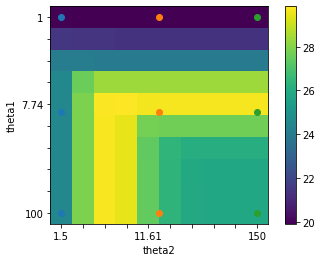

In [0]:
figure = plt.figure()
axes = figure.add_subplot(111)
axes.set_xlabel('theta2')
axes.set_ylabel('theta1')
axes.xaxis.set_ticks(range(10))
axes.xaxis.set_ticklabels(['1.5','', '' , '','11.61','','', '','', '150'])
axes.yaxis.set_ticks(range(10))
axes.yaxis.set_ticklabels(['1','', '' ,'','7.74','','', '','', '100'])
y1 = np.array([0,0,0])
y2 = np.array([4.5,4.5,4.5])
y3 = np.array([9,9,9])
axes.scatter(y1,[0,4.36,9])
axes.scatter(y2,[0,4.36,9])
axes.scatter(y3,[0,4.36,9])
plt.imshow(psnr_parrot, cmap='viridis')
plt.colorbar()
plt.show()

On remarque que le choix des valeurs des paramètres $\theta^1$ et $\theta^2$ impacte la qualité de l'image obtenue après débruitage (qualitativement, on remarque qu'on obtient des images mieux débruitées que d'autres dans la première expérience, et quantitativement (en terme du psnr), on remarque que le psnr entre  l'image réelle et l'image débruitée dépend du choix des paramètres).

Les points ajoutés dans la heatmap représentent l'emplacement des 6 images obtenues précédemment avec $\theta^1$ dans [1,10,100] et $\theta^2$ dans [1.5,15,150]. Ils ne sont pas représentés avec leurs valeurs de psnr car il s'agit d'une représentation 2D et ces valeurs de paramètres ne figurent pas dans les listes de valeurs choisies pour cette expérience, mais ils donnent une idée sur les psnr de ces images car les valeurs des paramètres sont proches des celles choisies et on remarque que les points avec un psnr élevé correspondent aux images les mieux débruitées. 

# SAPG : Stochastic Approximation Proximal Gradient
Le modèle TGV considéré dans cette expérience sort du cadre général présenté dans la partie théorique de la publication, car la loi à priori ne fait pas partie de la famille exponentielle. Ainsi, pour pouvoir appliquer les résultats de la publication, on écrit la loi à priori de la manière suivante :
$$p(x|\theta^1,\theta^2) = \frac{1}{Z(\theta^1,\theta^2)} exp[-\theta^1 g_1(x,\theta^1,\theta^2) -\theta^2 g_2(x,\theta^1,\theta^2) -\epsilon ||x||_2^2] $$
Avec :


*   $g_1(x,\theta^1,\theta^2) = ||r(x,\theta^1,\theta^2)||_{1,2}$
*   $g_2(x,\theta1,\theta2) = ||J(\Delta(x)-r(x,\theta^1,\theta^2))||_{1,Frob}$
*   $r(x,\theta^1,\theta^2) = argmin_{s \in \mathbb{R}^{2d}} \{ \theta^1 ||s||_{1,2} + \theta^2 ||J(\Delta(x)-s)||_{1,Frob} \}$

Dans chaque itération de l'algorithme SAPG, on met à jour le $\theta_n = (\theta^1_n,\theta^2_n)$ comme suit :
$$\theta_{n+1}^i = \Pi_{\Theta}(\theta^i_n + \delta_{n+1} \frac{\partial}{\partial \theta^i}log (p(y|\theta^1,\theta^2)), \; i\in \{1,2\}, \; \Pi_{\Theta} \; projection \; sur \; [0,+\infty)$$ 
En utilisant l'identité de Fisher (proposition 3), on a :
$$\frac{\partial}{\partial \theta^i}log p(y|\theta^1,\theta^2) = \int_{\mathbb{R}^d} p(x|y,\theta^1,\theta^2) \frac{\partial}{\partial \theta^i} log p(y,x|\theta^1,\theta^2) dx \\ = \int_{\mathbb{R}^d} p(x|y,\theta^1,\theta^2) \frac{\partial}{\partial \theta^i}log[p(y|x)p(x|\theta^1,\theta^2)] dx \\ = \int_
{\mathbb{R}^d} p(x|y,\theta^1,\theta^2) \frac{\partial}{\partial \theta^i} log[p(x|\theta^1,\theta^2)] dx $$

Et on utilise les approximations suivantes  :


*   $\frac{\partial}{\partial \theta^1} log[p(x|\theta^1,\theta^2)] = E_{x|\theta^1,\theta^2}[g_1(x,\theta^1,\theta^2)] - g_1(x,\theta^1,\theta^2)$
*   $\frac{\partial}{\partial \theta^1} log[p(x|\theta^1,\theta^2)] = E_{x|\theta^1,\theta^2}[g_2(x,\theta^1,\theta^2)] - g_2(x,\theta^1,\theta^2)$

Ainsi :
$$\frac{\partial}{\partial \theta^i}log p(y|\theta^1,\theta^2) = \int_{\mathbb{R}^d} p(x|\theta^1,\theta^2) g_i(x,\theta^1,\theta^2) dx - \int_{\mathbb{R}^d} p(x|y,\theta^1,\theta^2) g_i(x,\theta^1,\theta^2) dx$$

Ce qui nous permettra d'utiliser la version 3 de l'algorithme SAPG :

> 

1.   Choisir $\theta^1_0,\theta^2_0,X_0,\bar{X}_0,(\delta_n)_n,(\gamma_n)_n,(\gamma'_n)_n,N$
2.   pour n = 0,...,N-1 :
> * $X_{n+1} \sim R_{n,\gamma_n}(X_n,.)$
  * $\bar{X}_{n+1} \sim R_{n,\gamma'_n}(\bar{X}_n,.)$
  * $\theta^i_{n+1} = \Pi_\Theta[\theta^i_n + \delta_{n+1}(g_i(\bar{X}_n)-g_i(X_n))], \; i =1,2$
3. $\bar{\theta^i_N} = \frac{1}{N} \sum\limits_{k=1}^N \theta^i_k, \; i=1,2$

$X_{n+1} \sim R_{n,\gamma_n}(X_n,.)$ est obtenu avec la relation :
$X_{n+1} = X_n -\gamma \nabla_xF_1(X_n) - \gamma (X_n - prox_{TGV }^{\lambda}(X_n))/\lambda + \sqrt{2\gamma} Z_{n+1}$
Avec :
*   $F_1(x) = \frac{1}{2\sigma^2} ||x-y||^2_2 + \epsilon ||x||^2_2$ 
*   $(Z_k)_k$ un échantillon iid suivant la loi normale

$\bar{X}_{n+1} \sim R_{n,\gamma'_n}(\bar{X}_n,.)$ est obtenu avec la relation :
$\bar{X}_{n+1} = \bar{X}_n -\gamma' \nabla_xF_2(\bar{X}_n) - \gamma' (\bar{X}_n - prox_{TGV }^{\lambda'}(\bar{X}_n))/\lambda' + \sqrt{2\gamma'} Z_{n+1}$
Avec :
*   $F_2(x) = \epsilon ||x||^2_2$ 
*   $(Z_k)_k$ un échantillon iid suivant la loi normale

## Détermination de la fonction $prox^\lambda_{TGV}(x)$ et calcul de $g_1$ et $g_2$ :
On a :
$$prox^{\lambda}_{TGV}(x) = argmin_{x' \in \mathbb{R}^2} \frac{1}{2\lambda} ||x-x'||^2_2 + TGV(x')$$
On utilise le même solveur que précédemment, ainsi :
> On choisit les paramètres proximaux $\tau$ et $\tau'$, la suite des paramètres de relaxation $(\rho_n)_n$ et les valeurs initiales des variables primales $x$ et $r$ et de la variable duale u. pour $n \in \{0,...,Nbiter-1\}$ :

1.   $\tilde{x}_{n+1} = prox_{\tau F_x}(x_n - \tau \Delta^*(J^*(u_n))$
2.   $\tilde{r}_{n+1} = prox_{\tau F_r}(r_n + \tau J^*(u_n))$
3.   $\tilde{u}_{n+1} = prox_{\tau' G^*}(u_n - \tau' J(\Delta(2\tilde{x}_{n+1}-x_n)-2\tilde{r}_{n+1}-r_n)$
4.   $(x_{n+1},r_{n+1},u_{n+1}) = (1-\rho_n) * (x_{n},r_{n},u_{n}) + \rho_n * (\tilde{x}_{n+1},\tilde{r}_{n+1},\tilde{u}_{n+1}) $

Avec  :


*   $F_x(x) = \frac{1}{2\lambda} ||x'-x||^2_2 $ donc $prox_{\tau F_x}(x) = \frac{ x' + x \tau / \lambda }{1 +\tau/ \lambda}$
*   $F_r(r) = \theta^1 ||r||_{1,2}$ donc $prox_{\tau F_r}(r) = r - \frac{r}{max(||\frac{r}{\tau \theta^1}||_{1,2}^*,1)}$
* $G(u) = \theta^2||u||_{1,Frob}$ donc $prox_{\tau' G^*}(u) = \frac{u}{max(||\frac{u}{\theta^2}||_{1,Frob}^*,1)}$
* $L(x,r) = J(\Delta(x)-r)$

A la fin la fonction retourne $prox^{\lambda}_TGV(x)$, ie x_{Nbiter}, ainsi que : $g_1 = ||r_{Nbiter}||_{1,2}$ et $g_2 = ||J(\Delta(x_{Nbiter})-r_{Nbiter})||_{1,Frob} $. On a choisi de calculer $prox^\lambda_{TGV}(x)$, $g_1$ et $g_2$ dans la même fonction au lieu de définir une fonction TGV indépendente car on aura besoin de la fonction TGV appliquée au résultat de la fonction $prox^\lambda_{TGV}(x)$. Ceci nous a également permis de minimiser le temps de calcul.

On implémente cet algorithme dans la fonction TGV_prox ci-dessous.

In [5]:
def TGV_prox(x,theta1,theta2,tau,Nbiter,lam) :

    rho = 1.99
    tau_prime = 1/tau/72
    H,W=x.shape

    prox_tau_fx = lambda a : (a+tau*x/lam)/(1+tau/lam)
    opD = lambda a : np.stack((np.block([[np.diff(a,1,axis=0)],[np.zeros((1,W))]]),np.block([np.diff(a,1,axis=1),np.zeros((H,1))])),axis=-1) 
    opDadj = lambda u :  np.block([[-u[0,:,0].reshape(1,-1)],[-np.diff(u[0:-1,:,0],1,axis=0)],[u[-2,:,0].reshape(1,-1)]]) + np.block([-u[:,0,1].reshape(-1,1),-np.diff(u[:,0:-1,1],1,axis=1),u[:,-2,1].reshape(-1,1)])
    opJ = lambda r :  np.stack((np.block([[r[0,:,0].reshape(1,-1)],[np.diff(r[:,:,0],1,axis=0)]]),np.block([np.diff(r[:,:,0],1,axis=1),np.zeros((H,1))]),np.block([r[:,0,1].reshape(-1,1),np.diff(r[:,:,1],1,axis=1)]),np.block([[np.diff(r[:,:,1],1,axis=0)],[np.zeros((1,W))]])),axis=-1)
    opJadj = lambda u : np.stack((np.block([[-np.diff(u[:,:,0],1,axis=0)],[u[-1,:,0].reshape(1,-1)]]) - np.block([u[:,0,1].reshape(-1,1),np.diff(u[:,:,1],1,axis=1)]),np.block([-np.diff(u[:,:,2],1,axis=1),u[:,-1,2].reshape(-1,1)]) - np.block([[u[0,:,3].reshape(1,-1)],[np.diff(u[:,:,3],1,axis=0)]])),axis=-1)

    x2 = x
    x1 = x
    r2 = np.zeros((H,W,2))
    r = np.zeros((H,W,2))
    u2 = np.zeros((H,W,4))
 #A décommenter si on veut tester la convergence
    #start = time.time()
    #cost_list = []	
    for i in range(1,Nbiter+1):
        tmp = tau*opJadj(u2)
        x1 = prox_tau_fx(x2-opDadj(tmp))
        r = prox_tau_fr(r2+tmp,tau,theta1)
        u = prox_g_conj(u2+tau_prime*opJ(opD(2*x1-x2)-(2*r-r2)),theta2)
        x2 = x2+rho*(x1-x2)
        r2 = r2+rho*(r-r2)
        u2 = u2+rho*(u-u2)
    #A décommenter en phase de test et ajouter cost_list aux outputs si test
        #cost = norm(x-x1,'fro')**2/(2*lam)+theta1*np.sum(np.sum(np.sqrt(np.sum(puissance(r,2),2))))+theta2*np.sum(np.sum(np.sqrt(np.sum(puissance(opJ(opD(x1)-r),2),2))))
        #cost_list.append(cost)
        #if i%25 == 0 :
            #print("iter : ",i," cost : ",cost, "temps : ",time.time()-start)
    g1 = np.sum(np.sum(np.sqrt(np.sum(puissance(r,2),2))))
    g2 = np.sum(np.sum(np.sqrt(np.sum(puissance(opJ(opD(x1)-r),2),2))))
    return x1,g1,g2

## Implémentation du SAPG :

Comme mentionné dans l'article, on ajoute une étape d'initilisation des chaîne de Markov $(X_k)_k$ et $(\bar{X}_k)_k$ de T0 itérations. (warm-up initialisation)

On ajoute également une étape de thining de la chaîne de Markov $(\bar{X}_k)_k$ provonant de la loi à priori  vu qu'elle est plus lente que la chaîne provenant de la loi $p(x|y,\theta)$ en terme de convergence. Cette étape consiste à écarter t-1 échantillons toute les t itérations (i.e., we discard 5 every
6 samples as explained in Appendix B.3). 

La moyenne des paramètres $\theta_i, \; i=1,2$ est calculée à partir de $N_0$ itérations, i.e :
$$\bar{\theta}^{i}_N = \frac{1}{N-N_0} \sum\limits_{k=N_0}^N \theta^i_k$$

Pour les critères de convergence, on a : 

*   critère = 1 : s'arrêter après N itérations.
*   critère = 2 : s'arrêter quand $\frac{||\bar{\theta}_{n+1}-\bar{\theta}_{n}||_{\infty}}{||\bar{\theta}_{n}||_{\infty}} \leq 10^{-4}$ 
*   critère = 3 : s'arrêter quand $||\bar{\theta}_{n+1}-\bar{\theta}_{n}||_{\infty} \leq 10^{-3}$  

On choisit les mêmes valeurs de paramètres que celles choisies dans l'article, sauf pour le nombre maximal d'itérations où on se contente de 300 ou 500 itérations. (les contraintes menant à ce choix sont détaillées dans le rapport)

Les paramètres du solveur utilisé dans TGV_prox et TGVdenoising n'ont pas été précisé dans l'article, ainsi, on a choisi les paramètres réalisant le meilleur rapport temps de calcul/résultats ($\tau$ = 0.003 et Nbiter = 50 pour TGV_prox et Nbiter = 100 pour TGVdenoising).  




In [0]:
def SAPG(X_0,Xbar_0,y,theta1_0,theta2_0,sigma,critere,N,N0,T0,t) :
  L = (0.95/sigma)**2
  lam = min(5/L,2)
  gamma = 0.98/(L+1/lam)
  gamma_prime = 0.98*lam
  epsilon = 1e-10
  theta1 = [theta1_0]
  theta2 = [theta2_0]
  theta1_est = []
  theta2_est = []
  nl,nc = X_0.shape
  X = X_0
  Xbar = Xbar_0
  t1 = False
  t2 = False
  start = time.time()


  #warm-up initialization
  for k in range(T0) :
    g = (X-y)/sigma**2 + 2*epsilon*X
    x,g1,g2 = TGV_prox(X,theta1[-1],theta2[-1],0.003,50,lam)
    X = X -gamma*g - gamma*(X-x)/lam + sqrt(2*gamma) * np.random.randn(nl,nc) 
    gbar = 2*epsilon*Xbar
    xbar,g1bar,g2bar = TGV_prox(Xbar,theta1[-1],theta2[-1],0.003,50,lam)
    Xbar = Xbar - gamma_prime*gbar - gamma_prime*(Xbar-xbar)/lam + sqrt(2*gamma_prime) * np.random.randn(nl,nc) 
  print("Fin de la warm-up initialisation, time : ", time.time()-start)
  n=1
  start = time.time()
  while n <= N and t1==False and t2==False :
    #n +=1
    g = (X-y)/sigma**2 + 2*epsilon*X
    x,g1,g2 = TGV_prox(X,theta1[-1],theta2[-1],0.003,50,lam)
    X = X -gamma*g - gamma*(X-x)/lam + sqrt(2*gamma) * np.random.randn(nl,nc) 
    #thining pour la chaîne de Markov suivant la loi à priori
    for i in range(t) : 
      gbar = 2*epsilon*Xbar
      xbar,gbar1,gbar2 = TGV_prox(Xbar,theta1[-1],theta2[-1],0.003,50,lam)
      Xbar = Xbar -gamma_prime*gbar - gamma_prime*(Xbar-xbar)/lam + sqrt(2*gamma_prime) * np.random.randn(nl,nc) 
    delta = 20*(n**(-0.8))/(nl*nc)
    theta1.append(max(1e-3,theta1[-1]+delta*(gbar1-g1)))
    theta2.append(max(1e-3,theta2[-1]+delta*(gbar2-g2)))

    if n>N0 :
      theta1_est.append(np.mean(np.array(theta1[20:])))
      theta2_est.append(np.mean(np.array(theta2[20:])))

      if critere == 2 :
        if len(theta1_est)>= 2 :
          if max(np.abs(theta1_est[-1]-theta1_est[-2]),np.abs(theta2_est[-1]-theta2_est[-2]))/max(np.abs(theta1_est[-2]),np.abs(theta2_est[-2])) <= 1e-4 :
            t1 = True
            print("Critère 2, iter : ",n," time : ",time.time()-start)
      if critere == 3 :
        if len(theta1_est)>= 2 :
          if max(np.abs(theta1_est[-1]-theta1_est[-2]),np.abs(theta2_est[-1]-theta2_est[-2])) <= 1e-3:
            t2 = True
            print("Critère 3, iter : ",n," time : ",time.time()-start)
    if n%30 == 0 :
      print("iteration : ",n,"theta1 : ",theta1[-1]," theta2 : ",theta2[-1]," time : ", time.time()-start)
    n = n+1
  return theta1,theta2,theta1_est,theta2_est

## SAPG et TGVdenoising sur les deux images tests  : boat et lake avec SNR = 8

Comme mentionné dans l'article, l'application de SAPG sur une image entière est très coûteux en terme de temps de calcul. Ainsi, on l'applique sur un patch représentatif de l'image (255*255 par exemple), et on utilise les $\theta^i$ résultants dans l'algorithme de TGVdenoising sur l'image entière.

In [0]:
#définition des patchs sighificatifs à utiliser pour chaque image
patches = {'boat' : (145,400,190,445),'lake' : (195,450,95,350)}

In [0]:
#une fonction qui transforme une image en couleurs en une image grayscale
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [0]:
print('Image : boat, ','SNR = ',8,', Critère : 300 itérations')
N = 300
N0 = 20
T0 = 25
t = 6
SNR = 8
im = 'boat.png'
real = plt.imread('./im/'+im,0)/255
if len(real.shape) > 2 :
  real = rgb2gray(real)
nl,nc = real.shape
sigma = (10**(-SNR/10))*ndimage.mean(real)
y = real + np.random.randn(nl,nc)*sigma
np.save('boat8.npy', y)
plt.imsave('./im_noise/boat8.png',y)
p = patches[im[:-4]]
y_prime = y[p[0]:p[1],p[2]:p[3]]
theta1,theta2,theta1_est,theta2_est = SAPG(y_prime,y_prime,y_prime,10,10,sigma,1,N,N0,T0,t)
np.save('t1_boat.npy', theta1)
np.save('t2_boat.npy', theta2)
np.save('te1_boat.npy', theta1_est)
np.save('te2_boat.npy', theta2_est)
y_denoised = TGVdenoising(y,theta1_est[-1],theta2_est[-1],sigma,100)
plt.imsave('./im_denoised/boat8_d.png',y_denoised,cmap='gray',format='png')

Image : boat,  SNR =  8 , Critère : 300 itérations
Fin de la warm-up initialisation, time :  380.50164341926575
iteration :  30 theta1 :  9.99639355812693  theta2 :  9.958482242239507  time :  1541.1189181804657
iteration :  60 theta1 :  9.995203171401737  theta2 :  9.934687073693434  time :  3143.8951947689056
iteration :  90 theta1 :  9.994516267881584  theta2 :  9.909771132314255  time :  4754.333639860153
iteration :  120 theta1 :  9.993909851060195  theta2 :  9.900835361249737  time :  6382.0586495399475
iteration :  150 theta1 :  9.993458854882956  theta2 :  9.891975601141242  time :  8001.847815275192
iteration :  180 theta1 :  9.993093059967931  theta2 :  9.880972146198081  time :  9630.486211299896
iteration :  210 theta1 :  9.992758760417823  theta2 :  9.875436649182538  time :  11252.718618631363
iteration :  240 theta1 :  9.992434111744975  theta2 :  9.871834719076835  time :  12885.54555773735
iteration :  270 theta1 :  9.992157240117308  theta2 :  9.86683253418561  time :

In [0]:
peak_signal_noise_ratio(real,y_denoised)

28.9720139498764

In [0]:
print(theta1_est[-1],theta2_est[-1])

9.993607095339936 9.894897358086057


Afin de réaliser la heatmap du psnr en 2D et 3D, on calcule la valeur du psnr entre l'image réelle et celle obtenue par TGVdenoing pour différentes valeurs de $\theta^1$ et $\theta^2$. (Comme ce qu'on a fait avec l'image parrot).

In [0]:
Nbiter = 100
start = time.time()
im = 'boat.png'
real = plt.imread('./im/'+im,0)/255
if len(real.shape) > 2 :
  real = rgb2gray(real)
y = np.load('boat8.npy') #afin d'appliquer le TGVdenoising à la même image bruitée utilisée dans SAPG
SNR = 8
sigma = (10**(-SNR/10))*ndimage.mean(real)

theta1_list = np.exp(np.log(10)*np.linspace(-1,2,10)) 
theta2_list = np.exp(np.log(10)*np.linspace(2,-1,10)) 
psnr_boat = []
for theta2 in theta2_list :
  for theta1 in theta1_list :
    x2 = TGVdenoising(y,theta1,theta2,sigma,Nbiter)
    psnr_boat.append(peak_signal_noise_ratio(real,x2))
  print("temps écoulé : ",time.time()-start)

temps écoulé :  635.3346700668335
temps écoulé :  1272.863524198532
temps écoulé :  1911.0159509181976
temps écoulé :  2552.20321059227
temps écoulé :  3195.4516110420227
temps écoulé :  3841.327184677124
temps écoulé :  4491.696607589722
temps écoulé :  5134.718242645264
temps écoulé :  5777.867897987366
temps écoulé :  6422.383436203003


In [0]:
psnr_boat8

array([[22.20463452, 22.32950206, 22.60091192, 23.19569663, 24.50800782,
        27.28292525, 28.78936492, 25.76643178, 23.58415439, 23.37285461],
       [22.20463452, 22.32950206, 22.60091192, 23.19569663, 24.50800782,
        27.28292525, 28.78936492, 25.76643178, 23.81978561, 23.75426651],
       [22.20475054, 22.3296102 , 22.6010086 , 23.19576206, 24.50805601,
        27.28308194, 28.78875348, 25.91219992, 25.23001041, 25.23335927],
       [22.2063675 , 22.33117039, 22.60259814, 23.1972578 , 24.5097238 ,
        27.27908227, 28.56918457, 27.59556712, 27.64313303, 27.6448456 ],
       [22.21609362, 22.34135426, 22.61386161, 23.21050121, 24.52614186,
        27.34290469, 29.27572451, 29.16725399, 29.11561965, 29.11561965],
       [22.25212238, 22.38034486, 22.65791768, 23.27273117, 24.6565638 ,
        27.05364993, 27.15177526, 27.15177525, 27.15177525, 27.15177525],
       [22.54204168, 22.7176682 , 23.08256133, 23.90838396, 24.47749641,
        24.50516591, 24.50516591, 24.50516591

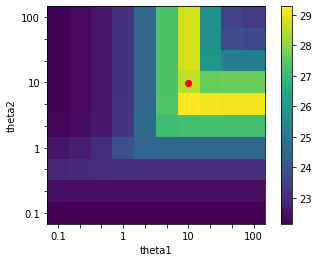

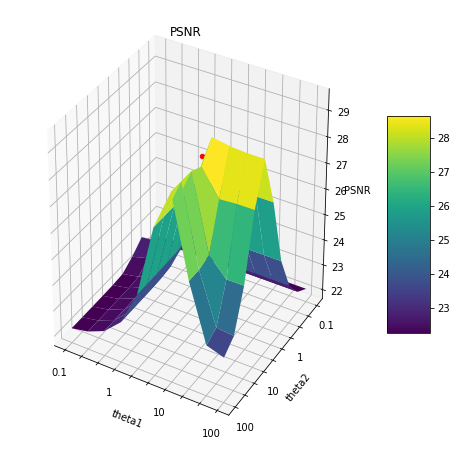

In [0]:
psnr_boat8 = np.array(psnr_boat).reshape((10,10))
figure = plt.figure()
axes = figure.add_subplot(111)
axes.set_xlabel('theta1')
axes.set_ylabel('theta2')
axes.xaxis.set_ticks(range(10))
axes.xaxis.set_ticklabels(['0.1','', '' , '1','','','10', '','', '100'])
axes.yaxis.set_ticks(range(10))
axes.yaxis.set_ticklabels(['100','', '' ,'10','','','1', '','', '0.1'])
plt.scatter(6+(1-np.log10(9.993607095339936))*3,3+(1-np.log10(9.894897358086057))*3,color='r')
plt.imshow(psnr_boat8, cmap='viridis')
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.set_xlabel('theta1')
ax.set_ylabel('theta2')
ax.set_zlabel('PSNR')
ax.xaxis.set_ticks(range(10))
ax.xaxis.set_ticklabels(['0.1','', '' , '1','','','10', '','', '100'])
ax.yaxis.set_ticks(range(10))
ax.yaxis.set_ticklabels(['100','', '' ,'10','','','1', '','', '0.1'])
ax.scatter(6+(1-np.log10(9.993607095339936))*3,3+(1-np.log10(9.894897358086057))*3,28.9720139498764,color='r')
X,Y = np.meshgrid(range(10),range(10))
surf = ax.plot_surface(X,Y,psnr_boat8,cmap='viridis')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('PSNR')
plt.show()

Le point rouge représente l'emplacement des paramètres obtenus avec l'algorithme SAPG. Il a été représenté avec sa valeur de psnr dans la heatmap 3D.

On remarque que le TGVdénoising avec les paramètres résultants de l'algorithme SAPG nous a donné une image débruitée de bonne qualité car son psnr est élevé par rapport aux autres valeurs de psnr obtenues avec d'autres valeurs (la valeur obtenue = 28.97 alors que le max des valeurs de psnr obtenues (psnr_boat8) est 29.27, le min est 22.14, la médiane 23.11 et la moyenne 24.15).

SAPG sur lake :

In [0]:
print('Image : lake, ','SNR = ',8,', Critère : 300 itérations')
N = 300
N0 = 20
T0 = 25
t = 6
SNR = 8
im = 'lake.png'
real = plt.imread('./im/'+im,0)/255
if len(real.shape) > 2 :
  real = rgb2gray(real)
nl,nc = real.shape
sigma = (10**(-SNR/10))*ndimage.mean(real)
y = real + np.random.randn(nl,nc)*sigma
np.save('lake8.npy', y)
plt.imsave('./im_noise/lake8.png',y,cmap='gray',format='png')
p = patches[im[:-4]]
y_prime = y[p[0]:p[1],p[2]:p[3]]
theta1,theta2,theta1_est,theta2_est = SAPG(y_prime,y_prime,y_prime,10,10,sigma,1,N,N0,T0,t)
np.save('t1_lake8.npy', theta1)
np.save('t2_lake8.npy', theta2)
np.save('te1_lake8.npy', theta1_est)
np.save('te2_lake8.npy', theta2_est)
y_denoised = TGVdenoising(y,theta1_est[-1],theta2_est[-1],sigma,100)
plt.imsave('./im_denoised/lake8_d.png',y_denoised,cmap='gray',format='png')

Image : lake,  SNR =  8 , Critère : 300 itérations
Fin de la warm-up initialisation, time :  362.6275568008423
iteration :  30 theta1 :  10.000257804410936  theta2 :  9.979777624941438  time :  1489.4132475852966
iteration :  60 theta1 :  10.000432783155789  theta2 :  9.977854164799341  time :  3036.956327676773
iteration :  90 theta1 :  10.000601762715608  theta2 :  9.975590147375746  time :  4585.711729764938
iteration :  120 theta1 :  10.000664791094202  theta2 :  9.977771144005573  time :  6168.137377023697
iteration :  150 theta1 :  10.000722303849141  theta2 :  9.97800670862174  time :  7753.670576810837
iteration :  180 theta1 :  10.000771327726815  theta2 :  9.97762495674924  time :  9337.247272491455
iteration :  210 theta1 :  10.00082556644169  theta2 :  9.976246601155585  time :  10914.982592105865
iteration :  240 theta1 :  10.0008843221862  theta2 :  9.975702404791962  time :  12467.651140451431
iteration :  270 theta1 :  10.000929652483293  theta2 :  9.978408360254146  ti

In [0]:
print(theta1_est[-1],theta2_est[-1])

10.00071012086871 9.977115850127419


In [0]:
peak_signal_noise_ratio(real,y_denoised)

28.802901933092162

Afin de réaliser la heatmap du psnr en 2D et 3D, on calcule la valeur du psnr entre l'image réelle et celle obtenue par TGVdenoing pour différentes valeurs de $\theta^1$ et $\theta^2$. (Comme ce qu'on a fait avec l'image parrot).

In [0]:
Nbiter = 100
start = time.time()
im = 'lake.png'
real = plt.imread('./im/'+im,0)/255
if len(real.shape) > 2 :
  real = rgb2gray(real)
y = np.load('lake8.npy')
SNR = 8
sigma = (10**(-SNR/10))*ndimage.mean(real)

theta1_list = np.exp(np.log(10)*np.linspace(-1,2,10)) 
theta2_list = np.exp(np.log(10)*np.linspace(2,-1,10)) 
psnr_lake = []
for theta2 in theta2_list :
  for theta1 in theta1_list :
    x2 = TGVdenoising(y,theta1,theta2,sigma,Nbiter)
    psnr_lake.append(peak_signal_noise_ratio(real,x2))
  print("temps écoulé : ",time.time()-start)

temps écoulé :  627.6215636730194
temps écoulé :  1258.1363501548767
temps écoulé :  1896.0398917198181
temps écoulé :  2540.201144695282
temps écoulé :  3185.158128261566
temps écoulé :  3830.2280611991882
temps écoulé :  4473.36604475975
temps écoulé :  5122.00550198555
temps écoulé :  5768.143991231918
temps écoulé :  6417.2943551540375


In [0]:
psnr_lake8

array([[22.47376525, 22.59090386, 22.84509704, 23.4001225 , 24.61445834,
        27.05760771, 28.85046923, 25.8103858 , 22.56285562, 22.45300183],
       [22.47376525, 22.59090386, 22.84509704, 23.4001225 , 24.61445834,
        27.05760771, 28.85046923, 25.70781397, 24.00884183, 23.99932551],
       [22.473946  , 22.59108197, 22.84526807, 23.40029917, 24.61466199,
        27.05781525, 28.85037603, 26.21274007, 25.96482062, 25.96476385],
       [22.48077459, 22.59818232, 22.85299163, 23.40890526, 24.6238984 ,
        27.06419065, 28.8088676 , 28.08156765, 28.0808015 , 28.08080149],
       [22.49425423, 22.61263487, 22.8692352 , 23.42940509, 24.65977475,
        27.23019329, 29.15611567, 29.15976664, 29.15976664, 29.15976664],
       [22.54967682, 22.67265492, 22.94161208, 23.53251804, 24.86757734,
        27.01940722, 27.09187109, 27.09187109, 27.09187109, 27.09187109],
       [22.87896227, 23.03739603, 23.39890446, 24.11281977, 24.61472882,
        24.63834197, 24.63834197, 24.63834197

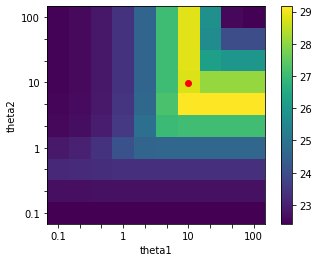

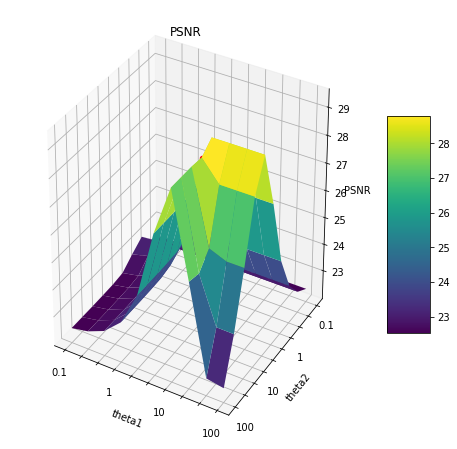

In [0]:
psnr_lake8 = np.array(psnr_lake).reshape((10,10))
np.save('psnr_lake8.npy',psnr_lake8)
figure = plt.figure()
axes = figure.add_subplot(111)
axes.set_xlabel('theta1')
axes.set_ylabel('theta2')
axes.xaxis.set_ticks(range(10))
axes.xaxis.set_ticklabels(['0.1','', '' , '1','','','10', '','', '100'])
axes.yaxis.set_ticks(range(10))
axes.yaxis.set_ticklabels(['100','', '' ,'10','','','1', '','', '0.1'])
plt.scatter(6+(-1+np.log10(10.00071012086871))*3,3+(1-np.log10(9.977115850127419))*3,color='r')
plt.imshow(psnr_lake8, cmap='viridis')
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.set_xlabel('theta1')
ax.set_ylabel('theta2')
ax.set_zlabel('PSNR')
ax.xaxis.set_ticks(range(10))
ax.xaxis.set_ticklabels(['0.1','', '' , '1','','','10', '','', '100'])
ax.yaxis.set_ticks(range(10))
ax.yaxis.set_ticklabels(['100','', '' ,'10','','','1', '','', '0.1'])
ax.scatter(6+(-1+np.log10(10.00071012086871))*3,3+(1-np.log10(9.977115850127419))*3,28.802901933092162,color='r')
X,Y = np.meshgrid(range(10),range(10))
surf = ax.plot_surface(X,Y,psnr_lake8,cmap='viridis')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('PSNR')
plt.show()

Le point rouge représente l'emplacement des paramètres obtenus avec l'algorithme SAPG. Il a été représenté avec sa valeur de psnr dans la heatmap 3D.

On remarque que le TGVdénoising avec les paramètres résultants de l'algorithme SAPG nous a donné une image lake débruitée de bonne qualité car son psnr est élevé par rapport aux autres valeurs de psnr obtenues avec d'autres valeurs (la valeur obtenue = 28.80 alors que le max des valeurs de psnr obtenues (psnr_boat8) est 29.15, le min est 22.41, la médiane 23.32 et la moyenne 24.31).

## Evolution de $\theta^1_k$,de $\theta^2_k$ ($k \in \{0,..,Nbiter\}$) et de leurs variations relatives pour l'image lake 8db

Pour le cas SNR = 8db, et vu qu'on a déjà appliqué SAPG à lake pour cette valeur du SNR, on prend les valeurs de paramètres obtenues dans l'expérience précédente.

In [ ]:
theta1 = np.load('t1_lake8.npy')
theta2 = np.load('t2_lake8.npy')
theta1_est = np.load('te1_lake8.npy')
theta2_est = np.load('te2_lake8.npy')

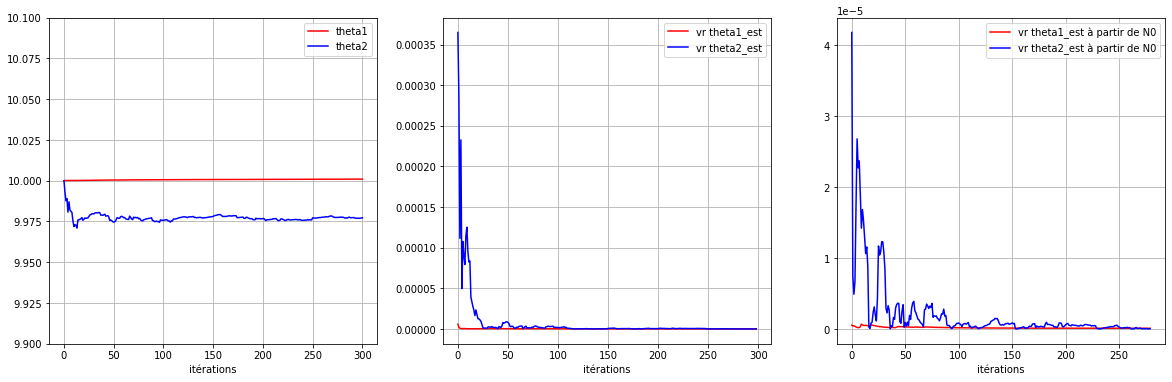

In [0]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(131)
axes.set_xlabel('itérations')
axes.set_ylim(9.9,10.1)
g1 = plt.plot(np.float32(np.array(theta1)),color='r',label="theta1")
g2 = plt.plot(np.float32(np.array(theta2)),color='b',label="theta2")
plt.legend(handles=[g1[0],g2[0]],loc='upper right')
plt.grid()

axes = figure.add_subplot(132)
axes.set_xlabel('itérations')
th1 = []
th2 = []
for i in range(1,len(theta1)) :
  th1.append(np.mean(np.array(theta1[:i])))
  th2.append(np.mean(np.array(theta2[:i])))
a = np.abs(np.diff(np.array(th1))/np.array(th1[:-1]))
g1 = plt.plot(a,color='r',label="vr theta1_est")
b = np.abs(np.diff(np.array(th2))/np.array(th2[:-1]))
g2 = plt.plot(b,color='b',label="vr theta2_est")
plt.legend(handles=[g1[0],g2[0]],loc='upper right')
plt.grid()

axes = figure.add_subplot(133)
axes.set_xlabel('itérations')
a = np.abs(np.diff(np.array(theta1_est))/np.array(theta1_est[:-1]))
g1 = plt.plot(a,color='r',label="vr theta1_est à partir de N0")
b = np.abs(np.diff(np.array(theta2_est))/np.array(theta2_est[:-1]))
g2 = plt.plot(b,color='b',label="vr theta2_est à partir de N0")
plt.legend(handles=[g1[0],g2[0]],loc='upper right')
plt.grid()

Le premier graphe représente la variation de $\theta^1$ et de $\theta^2$ tout au long des itérations. On remarque que dans cet exemple, la valeur des deux paramètres a rapidement converger vu que leur variations sont restées de l'ordre de $10^{-3}$.

Le deuxième graphe représente la variation relative de la moyenne des paramètres, i.e :
$$\frac{||\bar{\theta}_{n+1}-\bar{\theta}_{n}||_{\infty}}{||\bar{\theta}_{n}||_{\infty}}$$ avec $\bar{\theta}_n = \frac{1}{n} \sum\limits_{k=1}^n \theta_k, \; \theta_k = (\theta^1_k,\theta^2_k)^T$

On remarque que cette variation relative converge vers 0 rapidement (au bout de 50 itérations).

Le troisième graphe représente la variation relative de la moyenne des paramètres à partir de $N_0$ (ici $N_0 = 20$ itérations), i.e : 
$$pour \; n>N_0 \; :\; \frac{||\bar{\theta}_{n+1}-\bar{\theta}_{n}||_{\infty}}{||\bar{\theta}_{n}||_{\infty}}$$ avec $\bar{\theta}_n = \frac{1}{n-N_0} \sum\limits_{k=N_0}^n \theta_k, \; \theta_k = (\theta^1_k,\theta^2_k)^T$
On remarque  que cette variation est très petite (de l'ordre de $10^{-5}$), et elle tend vers 0.

## Evolution de $\theta^1_k$,de $\theta^2_k$ ($k \in \{0,..,Nbiter\}$) et de leurs variations relatives pour l'image lake 12db

SAPG sur lake 12db :

In [0]:
print('Image : lake, ','SNR = ',12,', Critère : 300 itérations')
N = 300
N0 = 20
T0 = 25
t = 6
SNR = 12
im = 'lake.png'
real = plt.imread('./im/'+im,0)/255
if len(real.shape) > 2 :
  real = rgb2gray(real)
nl,nc = real.shape
sigma = (10**(-SNR/10))*ndimage.mean(real)
y = real + np.random.randn(nl,nc)*sigma
np.save('lake12.npy', y)
plt.imsave('./im_noise/lake12.png',y,cmap='gray',format='png')
p = patches[im[:-4]]
y_prime = y[p[0]:p[1],p[2]:p[3]]
theta1,theta2,theta1_est,theta2_est = SAPG(y_prime,y_prime,y_prime,10,10,sigma,1,N,N0,T0,t)
np.save('t1_lake12.npy', theta1)
np.save('t2_lake12.npy', theta2)
np.save('te1_lake12.npy', theta1_est)
np.save('te2_lake12.npy', theta2_est)
y_denoised = TGVdenoising(y,theta1_est[-1],theta2_est[-1],sigma,100)
plt.imsave('./im_denoised/lake12_d.png',y_denoised,cmap='gray',format='png')

Image : lake,  SNR =  12 , Critère : 300 itérations
Fin de la warm-up initialisation, time :  394.95012974739075
iteration :  30 theta1 :  11.43511114047581  theta2 :  10.24848815215198  time :  1593.0031316280365
iteration :  60 theta1 :  11.807326700911961  theta2 :  10.211266661457557  time :  3233.076279401779
iteration :  90 theta1 :  11.993842660118263  theta2 :  10.170065269609132  time :  4871.443117618561
iteration :  120 theta1 :  12.152544122965834  theta2 :  10.130033174710208  time :  6508.163707494736
iteration :  150 theta1 :  12.241973945800721  theta2 :  10.116500903412883  time :  8144.193229436874
iteration :  180 theta1 :  12.309012776727647  theta2 :  10.096492256987228  time :  9778.210681438446
iteration :  210 theta1 :  12.355587776175847  theta2 :  10.077382046520968  time :  11410.641984939575
iteration :  240 theta1 :  12.414364130271194  theta2 :  10.052403788342772  time :  13031.018622636795
iteration :  270 theta1 :  12.463872728143667  theta2 :  10.03021

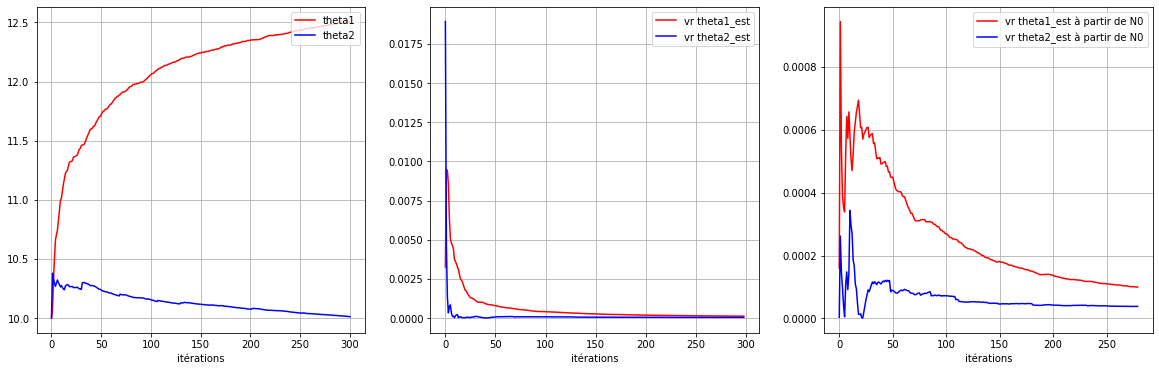

In [0]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(131)
axes.set_xlabel('itérations')
g1 = plt.plot(theta1,color='r',label="theta1")
g2 = plt.plot(theta2,color='b',label="theta2")
plt.legend(handles=[g1[0],g2[0]],loc='upper right')
plt.grid()

axes = figure.add_subplot(132)
axes.set_xlabel('itérations')
th1 = []
th2 = []
for i in range(1,len(theta1)) :
  th1.append(np.mean(np.array(theta1[:i])))
  th2.append(np.mean(np.array(theta2[:i])))
a = np.abs(np.diff(np.array(th1))/np.array(th1[:-1]))
g1 = plt.plot(a,color='r',label="vr theta1_est")
b = np.abs(np.diff(np.array(th2))/np.array(th2[:-1]))
g2 = plt.plot(b,color='b',label="vr theta2_est")
plt.legend(handles=[g1[0],g2[0]],loc='upper right')
plt.grid()

axes = figure.add_subplot(133)
axes.set_xlabel('itérations')
a = np.abs(np.diff(np.array(theta1_est))/np.array(theta1_est[:-1]))
g1 = plt.plot(a,color='r',label="vr theta1_est à partir de N0")
b = np.abs(np.diff(np.array(theta2_est))/np.array(theta2_est[:-1]))
g2 = plt.plot(b,color='b',label="vr theta2_est à partir de N0")
plt.legend(handles=[g1[0],g2[0]],loc='upper right')
plt.grid()

Le premier graphe représente la variation de $\theta^1$ et de $\theta^2$ tout au long des itérations. On remarque que dans cet exemple, la variation entre deux valeurs successives de ces paramètres diminue d'une itération à une autre (Elle est passée de l'ordre de $10^{-1}$ au début à $10^{-3}$ pour $\theta^1$ à la fin et $10^{-4}$ pour $\theta^2$ à la fin.

Le deuxième graphe représente la variation relative de la moyenne des paramètres, i.e :
$$\frac{||\bar{\theta}_{n+1}-\bar{\theta}_{n}||_{\infty}}{||\bar{\theta}_{n}||_{\infty}}$$ avec $\bar{\theta}_n = \frac{1}{n} \sum\limits_{k=1}^n \theta_k, \; \theta_k = (\theta^1_k,\theta^2_k)^T$

On remarque que cette variation relative converge vers 0  (au bout de de quelques itérations pour $\theta^2$ et de 150 itérations pour $\theta^1$).

Le troisième graphe représente la variation relative de la moyenne des paramètres à partir de $N_0$ (ici $N_0 = 20$ itérations), i.e : 
$$pour \; n>N_0 \; :\; \frac{||\bar{\theta}_{n+1}-\bar{\theta}_{n}||_{\infty}}{||\bar{\theta}_{n}||_{\infty}}$$ avec $\bar{\theta}_n = \frac{1}{n-N_0} \sum\limits_{k=N_0}^n \theta_k, \; \theta_k = (\theta^1_k,\theta^2_k)^T$
On remarque  que cette variation est très petite (de l'ordre de $10^{-4}$), et elle tend vers 0.

## Evolution de $\theta^1_k$,de $\theta^2_k$ ($k \in \{0,..,Nbiter\}$) et de leurs variations relatives pour l'image lake 20db

SAPG sur lake 20 db :

In [0]:
print('Image : lake, ','SNR = ',20,', Critère : 300 itérations')
N = 300
N0 = 20
T0 = 25
t = 6
SNR = 20
im = 'lake.png'
real = plt.imread('./im/'+im,0)/255
if len(real.shape) > 2 :
  real = rgb2gray(real)
nl,nc = real.shape
sigma = (10**(-SNR/10))*ndimage.mean(real)
y = real + np.random.randn(nl,nc)*sigma
np.save('lake20.npy', y)
plt.imsave('./im_noise/lake20.png',y,cmap='gray',format='png')
p = patches[im[:-4]]
y_prime = y[p[0]:p[1],p[2]:p[3]]
theta1,theta2,theta1_est,theta2_est = SAPG(y_prime,y_prime,y_prime,10,10,sigma,1,N,N0,T0,t)
np.save('t1_lake20.npy', theta1)
np.save('t2_lake20.npy', theta2)
np.save('te1_lake20.npy', theta1_est)
np.save('te2_lake20.npy', theta2_est)
y_denoised = TGVdenoising(y,theta1_est[-1],theta2_est[-1],sigma,100)
plt.imsave('./im_denoised/lake20_d.png',y_denoised,cmap='gray',format='png')

Image : lake,  SNR =  20 , Critère : 300 itérations
Fin de la warm-up initialisation, time :  386.0520017147064
iteration :  30 theta1 :  13.811516417957103  theta2 :  9.523230371147786  time :  1635.1717829704285
iteration :  60 theta1 :  14.685894543037916  theta2 :  8.94083974547558  time :  3276.8264331817627
iteration :  90 theta1 :  15.156045715216006  theta2 :  8.664233892203614  time :  4913.458305835724
iteration :  120 theta1 :  15.377247943823846  theta2 :  8.622970373947918  time :  6558.568792819977
iteration :  150 theta1 :  15.637188832697388  theta2 :  8.50194156373275  time :  8200.088819503784
iteration :  180 theta1 :  15.757271833480875  theta2 :  8.554844617469662  time :  9821.531071186066
iteration :  210 theta1 :  15.897416708649631  theta2 :  8.528576174747915  time :  11455.957459688187
iteration :  240 theta1 :  16.046812938137528  theta2 :  8.465217385313938  time :  13089.21271276474
iteration :  270 theta1 :  16.149583349688225  theta2 :  8.485997622509563

In [0]:
peak_signal_noise_ratio(real,y_denoised)

46.38329477915059

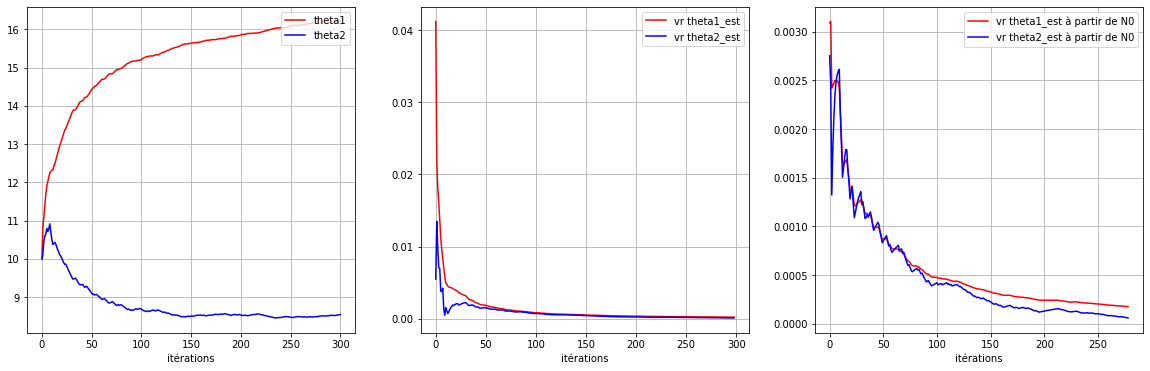

In [0]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(131)
axes.set_xlabel('itérations')
g1 = plt.plot(theta1,color='r',label="theta1")
g2 = plt.plot(theta2,color='b',label="theta2")
plt.legend(handles=[g1[0],g2[0]],loc='upper right')
plt.grid()

axes = figure.add_subplot(132)
axes.set_xlabel('itérations')
th1 = []
th2 = []
for i in range(1,len(theta1)) :
  th1.append(np.mean(np.array(theta1[:i])))
  th2.append(np.mean(np.array(theta2[:i])))
a = np.abs(np.diff(np.array(th1))/np.array(th1[:-1]))
g1 = plt.plot(a,color='r',label="vr theta1_est")
b = np.abs(np.diff(np.array(th2))/np.array(th2[:-1]))
g2 = plt.plot(b,color='b',label="vr theta2_est")
plt.legend(handles=[g1[0],g2[0]],loc='upper right')
plt.grid()

axes = figure.add_subplot(133)
axes.set_xlabel('itérations')
a = np.abs(np.diff(np.array(theta1_est))/np.array(theta1_est[:-1]))
g1 = plt.plot(a,color='r',label="vr theta1_est à partir de N0")
b = np.abs(np.diff(np.array(theta2_est))/np.array(theta2_est[:-1]))
g2 = plt.plot(b,color='b',label="vr theta2_est à partir de N0")
plt.legend(handles=[g1[0],g2[0]],loc='upper right')
plt.grid()

Le premier graphe représente la variation de $\theta^1$ et de $\theta^2$ tout au long des itérations. On remarque que dans cet exemple, la variation entre deux valeurs successives de ces paramètres diminuent d'une itération à une autre (Elle est passée de l'ordre de $10^{-1}$ au début à $10^{-4}$ pour $\theta^1$ à la fin et $10^{-3}$ pour $\theta^2$ à la fin.

Le deuxième graphe représente la variation relative de la moyenne des paramètres, i.e :
$$\frac{||\bar{\theta}_{n+1}-\bar{\theta}_{n}||_{\infty}}{||\bar{\theta}_{n}||_{\infty}}$$ avec $\bar{\theta}_n = \frac{1}{n} \sum\limits_{k=1}^n \theta_k, \; \theta_k = (\theta^1_k,\theta^2_k)^T$

On remarque que cette variation relative converge vers 0  (au bout de 150 itérations à peu près pour les deux paramètres).

Le troisième graphe représente la variation relative de la moyenne des paramètres à partir de $N_0$ (ici $N_0 = 20$ itérations), i.e : 
$$pour \; n>N_0 \; :\; \frac{||\bar{\theta}_{n+1}-\bar{\theta}_{n}||_{\infty}}{||\bar{\theta}_{n}||_{\infty}}$$ avec $\bar{\theta}_n = \frac{1}{n-N_0} \sum\limits_{k=N_0}^n \theta_k, \; \theta_k = (\theta^1_k,\theta^2_k)^T$
On remarque  que cette variation est très petite et elle adiminué pour passer de l'ordre de $10^{-3}$ au début à $10^{-4}$ à la fin.

## SAPG et TGVdenoising sur les 10 images tests avec SNR = 8,12,20


Les 1O images tests utilisées dans cette section sont les mêmes que celles utilisées dans l'article (sauf l'image wheel que j'ai remplacée par parrot) : barbara, boat, bridge, flintstones, goldhill, lake,
lena, man, mandrill et parrot (voir dossier im). On définit pour chacune de ces images le patch représentatif sur lequel on appliquera le SAPG. (voir plus haut la raison d'utulisation des patchs de petites tailles). Les résultats de cette partie sont regroupés dans le tableau 1 dans le rapport.

##### SNR 8 avec les  critères d'arrêt : (2) : $\frac{||\bar{\theta}_{N+1}-\bar{\theta}_{N}||_{\infty}}{||\bar{\theta}_{N}||_{\infty}} \leq 10^{-4}$ et (3) : $||\bar{\theta}_{N+1}-\bar{\theta}_{N}||_{\infty} \leq 10^{-3}$

In [0]:
patch = {'Lena' : (100,251,100,251),'barbara' : (0,200,300,500), 'boat' : (145,400,190,445), 'bridge' : (150,400,250,400),'flintstones' : (25,120,50,150), 'goldhill' : (150,400,350,500), 'lake' : (195,450,95,350),'man' : (50,350,200,450), 'mandrill' : (300,450,300,450), 'parrotgray' : (50,250,120,280) }

In [0]:
print('SNR = ',8,'Critère 2')
N = 300
N0 = 20
T0 = 25
t = 6
SNR = 8
psnr2n = dict()
time_dict2n = dict()
for im in os.listdir('./im') :
  real = plt.imread('./im/'+im,0)/255
  if len(real.shape) > 2 :
    real = rgb2gray(real)
  nl,nc = real.shape
  sigma = (10**(-SNR/10))*ndimage.mean(real)
  y = real + np.random.randn(nl,nc)*sigma
  print("image : "+im[:-4])
  p = patch[im[:-4]]
  y_prime = y[p[0]:p[1],p[2]:p[3]]
  start = time.time()
  theta1,theta2,theta1_est,theta2_est = SAPG(y_prime,y_prime,y_prime,10,10,sigma,2,N,N0,T0,t)
  time_dict2n[im[:-4]] = time.time()-start
  y_denoised = TGVdenoising(y,theta1_est[-1],theta2_est[-1],sigma,100)
  print("PSNR "+im[:-4]," ",peak_signal_noise_ratio(real,y_denoised))
  psnr2n[im[:-4]] = peak_signal_noise_ratio(real,y_denoised)
  f = open("psnr8_2n.pkl","wb")
  pickle.dump(psnr2n,f)
  f.close()
  f = open("time8_2n.pkl","wb")
  pickle.dump(time_dict2n,f)
  f.close()

SNR =  8 Critère 2
image : parrotgray
Fin de la warm-up initialisation, time :  175.11860394477844
iteration :  30 theta1 :  9.97650828568314  theta2 :  8.980157782796265  time :  739.2200417518616
iteration :  60 theta1 :  9.971464867495069  theta2 :  8.636647603913124  time :  1477.107780456543
iteration :  90 theta1 :  9.968635417022533  theta2 :  8.406617985399825  time :  2242.6256985664368
iteration :  120 theta1 :  9.966710717321915  theta2 :  8.222228159675128  time :  2982.6010937690735
iteration :  150 theta1 :  9.965196462759371  theta2 :  8.05882977736038  time :  3721.5076739788055
iteration :  180 theta1 :  9.963977840845049  theta2 :  7.928976976166768  time :  4472.662864685059
iteration :  210 theta1 :  9.963074672159824  theta2 :  7.805097177871994  time :  5223.092870473862
iteration :  240 theta1 :  9.962321005851866  theta2 :  7.694374496657122  time :  5982.487195968628
iteration :  270 theta1 :  9.961580131454923  theta2 :  7.588254367848484  time :  6751.7363202

In [0]:
psnr8_2 = pickle.load(open('psnr8_2n.pkl','rb'))
psnr8_2

{'Lena': 30.845292970316436,
 'barbara': 26.943747399610217,
 'boat': 28.745632344160764,
 'bridge': 26.967524098900345,
 'flintstones': 23.94956056768781,
 'goldhill': 29.99759801498337,
 'lake': 28.911832600948813,
 'man': 31.574907139523923,
 'mandrill': 24.581427745073903,
 'parrotgray': 32.57620424088501}

In [0]:
time8_2 = pickle.load(open('time8_2n.pkl','rb'))
time8_2

{'Lena': 5629.51012635231,
 'barbara': 992.9624106884003,
 'boat': 1584.2635743618011,
 'bridge': 3827.844360589981,
 'flintstones': 2361.644881248474,
 'goldhill': 1892.3656015396118,
 'lake': 1546.0924940109253,
 'man': 3857.823929786682,
 'mandrill': 1114.4185388088226,
 'parrotgray': 7684.555639266968}

On calcule la moyenne et l'écart type des valeurs du psnr et celles du temps nécessaire pour appliquer le SAPG. On obtient les résultat dans la cellule de code ci-dessous :

In [0]:
a = np.array([value for value in psnr8_2.values()])
print(np.mean(a),np.std(a))
b = np.array([value for value in time8_2.values()])
print(np.mean(b),np.std(b))

28.509372712209064 2.7363272613386735
3049.1481556653976 2087.8827319233287


On note que le temps de calcul n'est pas représentatif dans notre cas vu qu'on a utilisé des patchs de tailles différentes selon les images. Le résultats du psnr est par contre très proche de celui obtenu dans l'article (27 +- 2.85 dans l'article).

In [0]:
print('SNR = ',8,'Critère 3')
N = 300
N0 = 20
T0 = 25
t = 6
SNR = 8
psnr8_32 = dict()
time_dict8_32 = dict()
for im in os.listdir('./im') :
  real = plt.imread('./im/'+im,0)/255
  if len(real.shape) > 2 :
    real = rgb2gray(real)
  nl,nc = real.shape
  sigma = (10**(-SNR/10))*ndimage.mean(real)
  y = real + np.random.randn(nl,nc)*sigma
  print("image : "+im[:-4])
  p = patch[im[:-4]]
  y_prime = y[p[0]:p[1],p[2]:p[3]]
  start = time.time()
  theta1,theta2,theta1_est,theta2_est = SAPG(y_prime,y_prime,y_prime,10,10,sigma,3,N,N0,T0,t)
  time_dict8_32[im[:-4]] = time.time()-start
  y_denoised = TGVdenoising(y,theta1_est[-1],theta2_est[-1],sigma,100)
  print("PSNR "+im[:-4]," ",peak_signal_noise_ratio(real,y_denoised))
  psnr8_32[im[:-4]] = peak_signal_noise_ratio(real,y_denoised)
  f = open("psnr8_32.pkl","wb")
  pickle.dump(psnr8_32,f)
  f.close()
  f = open("time8_32.pkl","wb")
  pickle.dump(time_dict8_32,f)
  f.close()

SNR =  8 Critère 3
image : parrotgray
Fin de la warm-up initialisation, time :  187.3788869380951
iteration :  30 theta1 :  9.97298423982779  theta2 :  8.941144084110116  time :  771.0080614089966
iteration :  60 theta1 :  9.968015267731642  theta2 :  8.620295209346127  time :  1584.8947668075562
iteration :  90 theta1 :  9.96502186750498  theta2 :  8.388117994619074  time :  2393.58095908165
iteration :  120 theta1 :  9.962732424017778  theta2 :  8.192275105253431  time :  3229.2402968406677
iteration :  150 theta1 :  9.961189918408206  theta2 :  8.028879188807489  time :  4058.8905346393585
iteration :  180 theta1 :  9.960048731238741  theta2 :  7.8723822022028385  time :  4882.006434679031
iteration :  210 theta1 :  9.959194064349917  theta2 :  7.751520264890442  time :  5697.051310062408
iteration :  240 theta1 :  9.958308440345325  theta2 :  7.625557373509152  time :  6480.931506156921
iteration :  270 theta1 :  9.957595523021125  theta2 :  7.510309860223771  time :  7233.63334751

In [0]:
psnr8_32 = pickle.load(open('psnr8_32.pkl','rb'))
psnr8_32

{'Lena': 30.868046958827616,
 'barbara': 26.936775184792495,
 'boat': 29.01128897781787,
 'bridge': 26.794429829590104,
 'flintstones': 23.531545793276635,
 'goldhill': 29.97342357230709,
 'lake': 28.938554240276485,
 'man': 31.37266451397796,
 'mandrill': 24.53447215905761,
 'parrotgray': 32.8447653729535}

In [0]:
time8_32 = pickle.load(open('time8_32.pkl','rb'))
time8_32

{'Lena': 6066.83304977417,
 'barbara': 1053.896984577179,
 'boat': 1563.5465388298035,
 'bridge': 919.1123201847076,
 'flintstones': 2316.7035036087036,
 'goldhill': 2267.386435985565,
 'lake': 1544.6559691429138,
 'man': 2717.74915933609,
 'mandrill': 1099.0363729000092,
 'parrotgray': 8174.471875667572}

Pour le critère 3, on a :

PSNR = 28.480596660287738 $\pm$ 2.8481815604658784

time (en secondes) = 2772.3392210006714 $\pm$ 2294.7354990497547

(détails de calcul cellule code ci-dessous)

De même, on note que le temps de calcul n'est pas représentatif dans notre cas vu qu'on a utilisé des patchs de tailles différentes selon les images. Le résultats du psnr est par contre très proche de celui obtenu dans l'article (26.9 +- 2.97 dans l'article).

In [0]:
a = np.array([value for value in psnr8_32.values()])
print(np.mean(a),np.std(a))
b = np.array([value for value in time8_32.values()])
print(np.mean(b),np.std(b))

28.480596660287738 2.8481815604658784
2772.3392210006714 2294.7354990497547


##### SNR 12 avec les  critères d'arrêt : (2) : $\frac{||\bar{\theta}_{N+1}-\bar{\theta}_{N}||_{\infty}}{||\bar{\theta}_{N}||_{\infty}} \leq 10^{-4}$ et (3) : $||\bar{\theta}_{N+1}-\bar{\theta}_{N}||_{\infty} \leq 10^{-3}$

Afin d'améliorer les résultats, on a augementé le nombre d'itérations dans le cas du SNR=12 et SNR=20, et comme le temps de calcul ne doit pas dépasser 12 heures sur google colab, on a choisi de travailler uniquement avec 5 images dans ce cas. Ces 5 images sont : parrot, mandrill, flintstones, Lena et goldhill. 

In [0]:
print('SNR = ',12,'Critère 2')
N = 500
N0 = 20
T0 = 25
t = 6
SNR = 12
psnr12_2n = dict()
time_dict12_2n = dict()
im_list = ['parrotgray.png','mandrill.png','flintstones.png','Lena.png','goldhill.png']
for im in im_list :
  real = plt.imread('./im/'+im,0)/255
  if len(real.shape) > 2 :
    real = rgb2gray(real)
  nl,nc = real.shape
  sigma = (10**(-SNR/10))*ndimage.mean(real)
  y = real + np.random.randn(nl,nc)*sigma
  print("image : "+im[:-4])
  p = patch[im[:-4]]
  y_prime = y[p[0]:p[1],p[2]:p[3]]
  start = time.time()
  theta1,theta2,theta1_est,theta2_est = SAPG(y_prime,y_prime,y_prime,10,10,sigma,2,N,N0,T0,t)
  time_dict12_2n[im[:-4]] = time.time()-start
  y_denoised = TGVdenoising(y,theta1_est[-1],theta2_est[-1],sigma,100)
  print("PSNR "+im[:-4]," ",peak_signal_noise_ratio(real,y_denoised))
  psnr12_2n[im[:-4]] = peak_signal_noise_ratio(real,y_denoised)
  f = open("psnr12_2n.pkl","wb")
  pickle.dump(psnr12_2n,f)
  f.close()
  f = open("time12_2n.pkl","wb")
  pickle.dump(time_dict12_2n,f)
  f.close()

SNR =  12 Critère 2
image : parrotgray
Fin de la warm-up initialisation, time :  178.09380435943604
Critère 2, iter :  22  time :  545.6046342849731
PSNR parrotgray   35.096083617388906
image : mandrill
Fin de la warm-up initialisation, time :  122.67830014228821
iteration :  30 theta1 :  10.631324301300983  theta2 :  8.153273082790614  time :  523.0122878551483
iteration :  60 theta1 :  10.635516351519792  theta2 :  7.640015875034052  time :  1053.9835777282715
iteration :  90 theta1 :  10.628220526005983  theta2 :  7.266262086443095  time :  1577.9389579296112
iteration :  120 theta1 :  10.666241877761983  theta2 :  7.018713994875781  time :  2104.890032052994
iteration :  150 theta1 :  10.725231452347067  theta2 :  6.791701390935061  time :  2633.8119254112244
iteration :  180 theta1 :  10.759123020319178  theta2 :  6.619335400645123  time :  3155.8575251102448
iteration :  210 theta1 :  10.764972117569867  theta2 :  6.480706240205934  time :  3675.9000310897827
iteration :  240 the

On calcule la moyenne des psnr et du temps :

In [0]:
a = np.array([value for value in psnr12_2n.values()])
print(np.mean(a),np.std(a))
b = np.array([value for value in time_dict12_2n.values()])
print(np.mean(b),np.std(b))

33.29335872386922 1.9563538786982144
5243.166903305054 3630.6122914433213


In [0]:
psnr12_2n

{'Lena': 35.18124906629012,
 'flintstones': 30.707640993254707,
 'goldhill': 34.326204908388846,
 'mandrill': 31.155615034023533,
 'parrotgray': 35.096083617388906}

In [0]:
time_dict12_2n

{'Lena': 5497.882664442062,
 'flintstones': 1563.6119058132172,
 'goldhill': 9616.029614210129,
 'mandrill': 8814.610666513443,
 'parrotgray': 723.6996655464172}

In [0]:
print('SNR = ',12,'Critère 3')
N = 500
N0 = 20
T0 = 25
t = 6
SNR = 12
psnr12_3n = dict()
time_dict12_3n = dict()
im_list = ['parrotgray.png','mandrill.png','flintstones.png','Lena.png','goldhill.png']
for im in im_list :
  real = plt.imread('./im/'+im,0)/255
  if len(real.shape) > 2 :
    real = rgb2gray(real)
  nl,nc = real.shape
  sigma = (10**(-SNR/10))*ndimage.mean(real)
  y = real + np.random.randn(nl,nc)*sigma
  print("image : "+im[:-4])
  p = patch[im[:-4]]
  y_prime = y[p[0]:p[1],p[2]:p[3]]
  start = time.time()
  theta1,theta2,theta1_est,theta2_est = SAPG(y_prime,y_prime,y_prime,10,10,sigma,3,N,N0,T0,t)
  time_dict12_3n[im[:-4]] = time.time()-start
  y_denoised = TGVdenoising(y,theta1_est[-1],theta2_est[-1],sigma,100)
  print("PSNR "+im[:-4]," ",peak_signal_noise_ratio(real,y_denoised))
  psnr12_3n[im[:-4]] = peak_signal_noise_ratio(real,y_denoised)
  f = open("psnr12_3n.pkl","wb")
  pickle.dump(psnr12_3n,f)
  f.close()
  f = open("time12_3n.pkl","wb")
  pickle.dump(time_dict12_3n,f)
  f.close()

SNR =  12 Critère 3
image : parrotgray
Fin de la warm-up initialisation, time :  191.5217800140381
iteration :  30 theta1 :  10.257933139885727  theta2 :  10.193129428302269  time :  828.0442228317261
iteration :  60 theta1 :  10.378713508174462  theta2 :  10.244299672517913  time :  1651.5153665542603
iteration :  90 theta1 :  10.449391909884934  theta2 :  10.21965867935289  time :  2486.5643928050995
iteration :  120 theta1 :  10.525025142470572  theta2 :  10.175843128325315  time :  3304.496323823929
iteration :  150 theta1 :  10.57473855432178  theta2 :  10.14985035085125  time :  4111.355548381805
Critère 3, iter :  165  time :  4520.5499012470245
PSNR parrotgray   34.97068666190842
image : mandrill
Fin de la warm-up initialisation, time :  139.31663346290588
iteration :  30 theta1 :  9.888609146662937  theta2 :  8.75469720743852  time :  584.0447590351105
iteration :  60 theta1 :  10.07542313634357  theta2 :  8.258052366452228  time :  1148.4905745983124
iteration :  90 theta1 : 

In [0]:
psnr12_3n

{'Lena': 35.223829113230565,
 'flintstones': 30.5542906186812,
 'goldhill': 34.32007061595548,
 'mandrill': 31.05810353562342,
 'parrotgray': 34.97068666190842}

In [0]:
time_dict12_3n

{'Lena': 8062.5464408397675,
 'flintstones': 1191.9778995513916,
 'goldhill': 13166.679849147797,
 'mandrill': 9723.643554925919,
 'parrotgray': 4712.074011087418}

On calcule la moyenne des psnr et du temps de calcul :

In [0]:
a = np.array([value for value in psnr12_3n.values()])
print(np.mean(a),np.std(a))
b = np.array([value for value in time_dict12_3n.values()])
print(np.mean(b),np.std(b))

33.22539610907981 2.0034993137843644
7371.384351110459 4119.545457545253


##### SNR 20 avec les  critères d'arrêt : (2) : $\frac{||\bar{\theta}_{N+1}-\bar{\theta}_{N}||_{\infty}}{||\bar{\theta}_{N}||_{\infty}} \leq 10^{-4}$ et (3) : $||\bar{\theta}_{N+1}-\bar{\theta}_{N}||_{\infty} \leq 10^{-3}$

In [0]:
print('SNR = ',20,'Critère 2')
N = 500
N0 = 20
T0 = 25
t = 6
SNR = 20
psnr20_2n = dict()
time_dict20_2n = dict()
im_list = ['parrotgray.png','mandrill.png','flintstones.png','Lena.png','goldhill.png']
for im in im_list :
  real = plt.imread('./im/'+im,0)/255
  if len(real.shape) > 2 :
    real = rgb2gray(real)
  nl,nc = real.shape
  sigma = (10**(-SNR/10))*ndimage.mean(real)
  y = real + np.random.randn(nl,nc)*sigma
  print("image : "+im[:-4])
  p = patch[im[:-4]]
  y_prime = y[p[0]:p[1],p[2]:p[3]]
  start = time.time()
  theta1,theta2,theta1_est,theta2_est = SAPG(y_prime,y_prime,y_prime,10,10,sigma,2,N,N0,T0,t)
  time_dict20_2n[im[:-4]] = time.time()-start
  y_denoised = TGVdenoising(y,theta1_est[-1],theta2_est[-1],sigma,100)
  print("PSNR "+im[:-4]," ",peak_signal_noise_ratio(real,y_denoised))
  psnr20_2n[im[:-4]] = peak_signal_noise_ratio(real,y_denoised)
  f = open("psnr20_2n.pkl","wb")
  pickle.dump(psnr20_2n,f)
  f.close()
  f = open("time20_2n.pkl","wb")
  pickle.dump(time_dict20_2n,f)
  f.close()

SNR =  20 Critère 2
image : parrotgray
Fin de la warm-up initialisation, time :  184.35780954360962
iteration :  30 theta1 :  13.244522317950972  theta2 :  9.104605939415228  time :  830.3027403354645
iteration :  60 theta1 :  13.439957908659268  theta2 :  9.086845730043855  time :  1638.9498188495636
iteration :  90 theta1 :  13.700928363542282  theta2 :  8.879190299048004  time :  2433.408653974533
iteration :  120 theta1 :  13.998489867071909  theta2 :  8.622936043169519  time :  3222.365965604782
iteration :  150 theta1 :  14.319632968670849  theta2 :  8.30448167839625  time :  4008.422553062439
iteration :  180 theta1 :  14.493711354220943  theta2 :  8.145025101700568  time :  4846.39669585228
iteration :  210 theta1 :  14.691304237682747  theta2 :  8.04607750681186  time :  5646.612721920013
iteration :  240 theta1 :  14.675327511975173  theta2 :  8.09046564177097  time :  6427.963922739029
iteration :  270 theta1 :  14.755768044386429  theta2 :  8.061399634305069  time :  7208.6

In [0]:
psnr20_2n

{'Lena': 48.438188626302775,
 'flintstones': 45.89848984762868,
 'goldhill': 47.406639634510306,
 'mandrill': 45.945506643994456,
 'parrotgray': 47.127585911327}

In [0]:
time_dict20_2n

{'Lena': 2640.005198955536,
 'flintstones': 3321.4005749225616,
 'goldhill': 16359.810051202774,
 'mandrill': 4241.6926856040955,
 'parrotgray': 10562.34120631218}

Calcul de la moyenne des psnr et du temps de calcul :

In [0]:
a = np.array([value for value in psnr20_2n.values()])
print(np.mean(a),np.std(a))
b = np.array([value for value in time_dict20_2n.values()])
print(np.mean(b),np.std(b))

46.963282132752646 0.9558828721879505
7425.049943399429 5282.85698138482


In [0]:
print('SNR = ',20,'Critère 3')
N = 500
N0 = 20
T0 = 25
t = 6
SNR = 20
psnr20_3n = dict()
time_dict20_3n = dict()
im_list = ['parrotgray.png','mandrill.png','flintstones.png','Lena.png','goldhill.png']
for im in im_list :
  real = plt.imread('./im/'+im,0)/255
  if len(real.shape) > 2 :
    real = rgb2gray(real)
  nl,nc = real.shape
  sigma = (10**(-SNR/10))*ndimage.mean(real)
  y = real + np.random.randn(nl,nc)*sigma
  print("image : "+im[:-4])
  p = patch[im[:-4]]
  y_prime = y[p[0]:p[1],p[2]:p[3]]
  start = time.time()
  theta1,theta2,theta1_est,theta2_est = SAPG(y_prime,y_prime,y_prime,10,10,sigma,3,N,N0,T0,t)
  time_dict20_3n[im[:-4]] = time.time()-start
  y_denoised = TGVdenoising(y,theta1_est[-1],theta2_est[-1],sigma,100)
  print("PSNR "+im[:-4]," ",peak_signal_noise_ratio(real,y_denoised))
  psnr20_3n[im[:-4]] = peak_signal_noise_ratio(real,y_denoised)
  f = open("psnr20_3n.pkl","wb")
  pickle.dump(psnr20_3n,f)
  f.close()
  f = open("time20_3n.pkl","wb")
  pickle.dump(time_dict20_3n,f)
  f.close()

SNR =  20 Critère 3
image : parrotgray
Fin de la warm-up initialisation, time :  174.96019196510315
iteration :  30 theta1 :  14.060231729023737  theta2 :  9.957067650473803  time :  738.4632542133331
iteration :  60 theta1 :  14.482684261003774  theta2 :  9.40675705766319  time :  1488.332837343216
iteration :  90 theta1 :  14.769451433306932  theta2 :  8.980247848005662  time :  2236.076009750366
iteration :  120 theta1 :  14.905906155873117  theta2 :  8.796954894748401  time :  2980.090376138687
iteration :  150 theta1 :  14.79901768607798  theta2 :  8.869161436485541  time :  3721.438853263855
iteration :  180 theta1 :  14.810237750005435  theta2 :  8.839913660691892  time :  4470.808178424835
iteration :  210 theta1 :  14.9207439421051  theta2 :  8.804726415754457  time :  5223.510124206543
iteration :  240 theta1 :  15.045289612811455  theta2 :  8.686502069263268  time :  5976.52398109436
iteration :  270 theta1 :  15.087627448791045  theta2 :  8.708053256855667  time :  6724.467

In [8]:
psnr20_3n

{'Lena': 48.42493209688438,
 'flintstones': 45.8984651079329,
 'goldhill': 47.36925784604584,
 'mandrill': 45.953306375786376,
 'parrotgray': 47.14511279094062}

In [10]:
time_dict20_3n

{'Lena': 9290.531529426575,
 'flintstones': 2675.210258960724,
 'goldhill': 12852.132850408554,
 'mandrill': 3358.5089139938354,
 'parrotgray': 8047.7451956272125}

On calcule la moyenne des psnr et du temps de calcul :

In [11]:
a = np.array([value for value in psnr20_3n.values()])
print(np.mean(a),np.std(a))
b = np.array([value for value in time_dict20_3n.values()])
print(np.mean(b),np.std(b))

46.95821484351802 0.9474235826273197
7244.82574968338 3801.4820524687175


## SAPG et TGVdenoising sur l'image flintstones avec SNR = 12db

On applique l’algorithme SAPG sur l’image test flintstones avec SNR = 12 db pour differentes valeurs initiales $\theta_0^1=\theta_0^2= 0.1$,$\theta_0^1=\theta_0^2= 10$, et $\theta_0^1=\theta_0^2= 40$. Dans chaque cas, on applique SAPG à l'image bruitée, ensuite on la débruite avec les valeurs $\theta^1$ et $\theta^2$ de chaque iterations de SAPG, et de on calcule le psnr entre l’image reelle et l’image débruitee. A la fin, on représente l’évolution des paramètres et du psnr dans chaque cas.

SAPG flintstones 12db $\theta_0^1=\theta_0^2= 10$ :

In [0]:
print('Image : flintstones, ','SNR = ',12,', Critère : 3')
N = 400
N0 = 20
T0 = 25
t = 6
SNR = 12
im = 'flintstones.png'
real = plt.imread('./im/'+im,0)/255
if len(real.shape) > 2 :
  real = rgb2gray(real)
nl,nc = real.shape
sigma = (10**(-SNR/10))*ndimage.mean(real)
y = real + np.random.randn(nl,nc)*sigma
np.save('flintstones12.npy', y)
plt.imsave('./im_noise/flintstones12.png',y,cmap='gray',format='png')
p = patch[im[:-4]]
y_prime = y[p[0]:p[1],p[2]:p[3]]
theta1,theta2,theta1_est,theta2_est = SAPG(y_prime,y_prime,y_prime,10,10,sigma,1,N,N0,T0,t)
np.save('t1_flintstones12.npy', theta1)
np.save('t2_flintstones12.npy', theta2)
np.save('te1_flintstones12.npy', theta1_est)
np.save('te2_flintstones12.npy', theta2_est)
y_denoised = TGVdenoising(y,theta1_est[-1],theta2_est[-1],sigma,100)
plt.imsave('./im_denoised/flintstones12_d.png',y_denoised,cmap='gray',format='png')

Image : flintstones,  SNR =  12 , Critère : 3
Fin de la warm-up initialisation, time :  53.95806121826172
iteration :  30 theta1 :  6.606501908144652  theta2 :  9.924656328382255  time :  226.03758764266968
iteration :  60 theta1 :  6.3725775034379835  theta2 :  9.850138292568996  time :  451.26061630249023
iteration :  90 theta1 :  6.294288678599929  theta2 :  9.799781681268223  time :  675.855878829956
iteration :  120 theta1 :  6.231042563806938  theta2 :  9.776022419806951  time :  900.6423687934875
iteration :  150 theta1 :  6.2107302005585465  theta2 :  9.749220380979692  time :  1126.044414281845
iteration :  180 theta1 :  6.197151872461588  theta2 :  9.736389151266385  time :  1350.67462849617
iteration :  210 theta1 :  6.1770261379146305  theta2 :  9.739200195654426  time :  1575.762034893036
iteration :  240 theta1 :  6.176654741088632  theta2 :  9.724815791384968  time :  1801.203229188919
iteration :  270 theta1 :  6.1696372811389795  theta2 :  9.722973475887331  time :  20

Calcul du psnr pour les paramètres de chaque itération :

In [0]:
theta1_10 = np.load('t1_flintstones12.npy')
theta2_10 = np.load('t2_flintstones12.npy')
SNR = 12
im = 'flintstones.png'
real = plt.imread('./im/'+im,0)/255
if len(real.shape) > 2 :
  real = rgb2gray(real)
nl,nc = real.shape
sigma = (10**(-SNR/10))*ndimage.mean(real)
y = np.load('flintstones12.npy')
start = time.time()
psnr_flint_10 = []
n = 1
for t1,t2 in zip(theta1_10,theta2_10) :
    n = n+1
    y_denoised = TGVdenoising(y,t1,t2,sigma,100)
    psnr_flint_10.append(peak_signal_noise_ratio(real,y_denoised))
    if n%100==0 :
      print('temps écoulé : ',time.time()-start)
np.save('psnr_flint_10.npy',psnr_flint_10)

temps écoulé :  1105.3095853328705
temps écoulé :  2210.388006210327
temps écoulé :  3307.6052510738373
temps écoulé :  4400.970282316208


SAPG flintstones 12db $\theta_0^1=\theta_0^2= 0.1$ :

In [0]:
print('Image : flintstones, ','SNR = ',12,', Critère : 3')
N = 400
N0 = 20
T0 = 25
t = 6
SNR = 12
im = 'flintstones.png'
real = plt.imread('./im/'+im,0)/255
if len(real.shape) > 2 :
  real = rgb2gray(real)
nl,nc = real.shape
sigma = (10**(-SNR/10))*ndimage.mean(real)
y = np.load('flintstones12.npy')
p = patch[im[:-4]]
y_prime = y[p[0]:p[1],p[2]:p[3]]
theta1,theta2,theta1_est,theta2_est = SAPG(y_prime,y_prime,y_prime,0.1,0.1,sigma,1,N,N0,T0,t)
np.save('t1_flintstones12_01.npy', theta1)
np.save('t2_flintstones12_01.npy', theta2)
np.save('te1_flintstones12_01.npy', theta1_est)
np.save('te2_flintstones12_01.npy', theta2_est)
y_denoised = TGVdenoising(y,theta1_est[-1],theta2_est[-1],sigma,100)
plt.imsave('./im_denoised/flintstones12_d_01.png',y_denoised,cmap='gray',format='png')

Image : flintstones,  SNR =  12 , Critère : 3
Fin de la warm-up initialisation, time :  53.66463088989258
iteration :  30 theta1 :  7.842374866864303  theta2 :  34.0153593966861  time :  223.71760749816895
iteration :  60 theta1 :  7.072947469270267  theta2 :  34.03908963835604  time :  446.9755961894989
iteration :  90 theta1 :  6.765815846528617  theta2 :  34.01039941390829  time :  670.4424903392792
iteration :  120 theta1 :  6.590125575014702  theta2 :  33.98988158211708  time :  892.4333453178406
iteration :  150 theta1 :  6.488380105349143  theta2 :  33.96675198209925  time :  1116.969022989273
iteration :  180 theta1 :  6.411561989405381  theta2 :  33.94876886699795  time :  1341.4425690174103
iteration :  210 theta1 :  6.36054797016667  theta2 :  33.9412028151418  time :  1565.9568545818329
iteration :  240 theta1 :  6.329509534084263  theta2 :  33.92697174197669  time :  1788.0859446525574
iteration :  270 theta1 :  6.297862912890301  theta2 :  33.92529748148237  time :  2011.

psnr pour les paramètres de chaque itérations :

In [0]:
theta1_01 = np.load('t1_flintstones12_01.npy')
theta2_01 = np.load('t2_flintstones12_01.npy')
SNR = 12
im = 'flintstones.png'
real = plt.imread('./im/'+im,0)/255
if len(real.shape) > 2 :
  real = rgb2gray(real)
nl,nc = real.shape
sigma = (10**(-SNR/10))*ndimage.mean(real)
y = np.load('flintstones12.npy')
start = time.time()
psnr_flint_01 = []
n = 1
for t1,t2 in zip(theta1_01,theta2_01) :
    n = n+1
    y_denoised = TGVdenoising(y,t1,t2,sigma,100)
    psnr_flint_01.append(peak_signal_noise_ratio(real,y_denoised))
    if n%100==0 :
      print('temps écoulé : ',time.time()-start)
np.save('psnr_flint_01.npy',psnr_flint_01)

temps écoulé :  1146.158932209015
temps écoulé :  2301.2735862731934
temps écoulé :  3452.765998363495
temps écoulé :  4611.1359741687775


SAPG flintstones 12db $\theta_0^1=\theta_0^2= 40$

In [0]:
print('Image : flintstones, ','SNR = ',12,', Critère : 3')
N = 400
N0 = 20
T0 = 25
t = 6
SNR = 12
im = 'flintstones.png'
real = plt.imread('./im/'+im,0)/255
if len(real.shape) > 2 :
  real = rgb2gray(real)
nl,nc = real.shape
sigma = (10**(-SNR/10))*ndimage.mean(real)
y = np.load('flintstones12.npy')
p = patch[im[:-4]]
y_prime = y[p[0]:p[1],p[2]:p[3]]
theta1,theta2,theta1_est,theta2_est = SAPG(y_prime,y_prime,y_prime,40,40,sigma,1,N,N0,T0,t)
np.save('t1_flintstones12_40.npy', theta1)
np.save('t2_flintstones12_40.npy', theta2)
np.save('te1_flintstones12_40.npy', theta1_est)
np.save('te2_flintstones12_40.npy', theta2_est)
y_denoised = TGVdenoising(y,theta1_est[-1],theta2_est[-1],sigma,100)
plt.imsave('./im_denoised/flintstones12_d_40.png',y_denoised,cmap='gray',format='png')

Image : flintstones,  SNR =  12 , Critère : 3
Fin de la warm-up initialisation, time :  53.41691827774048
iteration :  30 theta1 :  40.0  theta2 :  38.39496142154466  time :  224.48620629310608
iteration :  60 theta1 :  40.0  theta2 :  37.957539965631426  time :  449.5660502910614
iteration :  90 theta1 :  40.0  theta2 :  37.66732207092185  time :  674.336089849472
iteration :  120 theta1 :  39.999985808573925  theta2 :  37.44692832283725  time :  900.5999612808228
iteration :  150 theta1 :  39.99995176393257  theta2 :  37.26560591429685  time :  1127.295395374298
iteration :  180 theta1 :  39.99995176393257  theta2 :  37.11226843185235  time :  1351.358802318573
iteration :  210 theta1 :  39.99995176393257  theta2 :  36.97684117665424  time :  1575.0264029502869
iteration :  240 theta1 :  39.99994856067671  theta2 :  36.85794685889555  time :  1797.194908618927
iteration :  270 theta1 :  39.99994856067671  theta2 :  36.749337870907425  time :  2022.3319890499115
iteration :  300 theta

psnr pour les valeurs de paramètres de chaque itérations :

In [0]:
theta1_40 = np.load('t1_flintstones12_40.npy')
theta2_40 = np.load('t2_flintstones12_40.npy')
SNR = 12
im = 'flintstones.png'
real = plt.imread('./im/'+im,0)/255
if len(real.shape) > 2 :
  real = rgb2gray(real)
nl,nc = real.shape
sigma = (10**(-SNR/10))*ndimage.mean(real)
y = np.load('flintstones12.npy')
start = time.time()
psnr_flint_40 = []
n = 1
for t1,t2 in zip(theta1_40,theta2_40) :
    n = n+1
    y_denoised = TGVdenoising(y,t1,t2,sigma,100)
    psnr_flint_40.append(peak_signal_noise_ratio(real,y_denoised))
    if n%100==0 :
      print('temps écoulé : ',time.time()-start)
np.save('psnr_flint_40.npy',psnr_flint_40)

temps écoulé :  1173.6127252578735
temps écoulé :  2345.4484734535217
temps écoulé :  3525.9315519332886
temps écoulé :  4729.253422498703


Calcul du psnr pour différentes valeurs de paramètres afin de tracer la heatmap 3D :

In [0]:
SNR = 12
im = 'flintstones.png'
real = plt.imread('./im/'+im,0)/255
if len(real.shape) > 2 :
  real = rgb2gray(real)
nl,nc = real.shape
sigma = (10**(-SNR/10))*ndimage.mean(real)
y = np.load('flintstones12.npy')
start = time.time()
psnr_flint = []


theta1_list = np.exp(np.log(10)*np.linspace(-1,2,10)) 
theta2_list = np.exp(np.log(10)*np.linspace(2,-1,10)) 

for theta2 in theta2_list :
  for theta1 in theta1_list :
    x2 = TGVdenoising(y,theta1,theta2,sigma,100)
    psnr_flint.append(peak_signal_noise_ratio(real,x2))
  print("temps écoulé : ",time.time()-start)
np.save('psnr_f.npy',psnr_flint)

temps écoulé :  120.21477317810059
temps écoulé :  242.81202363967896
temps écoulé :  365.6916582584381
temps écoulé :  490.74966764450073
temps écoulé :  609.2155427932739
temps écoulé :  728.3874406814575
temps écoulé :  846.473400592804
temps écoulé :  966.1009719371796
temps écoulé :  1083.8268177509308
temps écoulé :  1200.8040659427643


In [0]:
#fonctions utilisées pour ajuster les valeurs des paramètres aux échelles logarithmiques utilisées
def adjust2(t2) :
  res = []
  for t in t2 :
    res.append((2-np.log10(t))*3)
  return res
def adjust1(t1) :
  res = []
  for t in t1 :
    res.append((1+np.log10(t))*3)
  return res

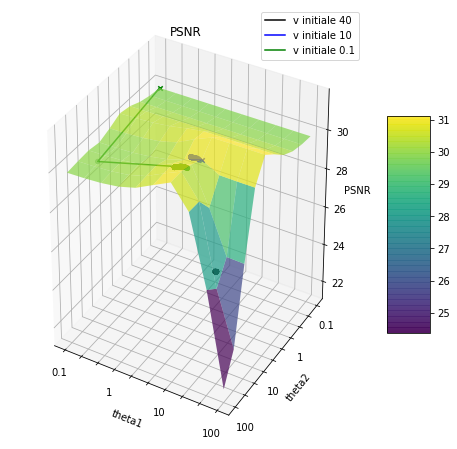

In [0]:
theta1_40 = np.load('t1_flintstones12_40.npy')
theta2_40 = np.load('t2_flintstones12_40.npy')
psnr_flint_40 = np.load('psnr_flint_40.npy')
theta1_01 = np.load('t1_flintstones12_01.npy')
theta2_01 = np.load('t2_flintstones12_01.npy')
psnr_flint_01 = np.load('psnr_flint_01.npy')
theta1_10 = np.load('t1_flintstones12.npy')
theta2_10 = np.load('t2_flintstones12.npy')
psnr_flint_10 = np.load('psnr_flint_10.npy')
psnr_flint = np.load('psnr_f.npy')
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.set_xlabel('theta1')
ax.set_ylabel('theta2')
ax.set_zlabel('PSNR')
ax.xaxis.set_ticks(range(10))
ax.xaxis.set_ticklabels(['0.1','', '' , '1','','','10', '','', '100'])
ax.yaxis.set_ticks(range(10))
ax.yaxis.set_ticklabels(['100','', '' ,'10','','','1', '','', '0.1'])
ax.scatter(adjust1(theta1_40)[1:],adjust2(theta2_40)[1:],psnr_flint_40[1:],color='k',marker='o')
ax.scatter(adjust1(theta1_40)[0],adjust2(theta2_40)[0],psnr_flint_40[0],color='k',marker='x')
ax.plot3D(adjust1(theta1_40),adjust2(theta2_40),psnr_flint_40,color='k',label='v initiale 40')
ax.scatter(adjust1(theta1_10)[1:],adjust2(theta2_10)[1:],psnr_flint_10[1:],color='b',marker='o')
ax.scatter(adjust1(theta1_10)[0],adjust2(theta2_10)[0],psnr_flint_10[0],color='b',marker='x')
ax.plot3D(adjust1(theta1_10),adjust2(theta2_10),psnr_flint_10,color='b',label='v initiale 10')
ax.scatter(adjust1(theta1_01)[1:],adjust2(theta2_01)[1:],psnr_flint_01[1:],color='g',marker='o')
ax.scatter(adjust1(theta1_01)[0],adjust2(theta2_01)[0],psnr_flint_01[0],color='g',marker='x')
ax.plot3D(adjust1(theta1_01),adjust2(theta2_01),psnr_flint_01,color='g',label='v initiale 0.1')
a = np.array(psnr_flint).reshape((10,10))
X,Y = np.meshgrid(range(10),range(10))
surf = ax.plot_surface(X,Y,a,cmap='viridis',alpha=0.7)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('PSNR')
plt.legend()
plt.show()

On remarque que dans les deux cas $\theta_0^1 = \theta_0^2 = 0.1$ et $\theta_0^1 = \theta_0^2 = 10$, l'algorithme SAPG a convergé rapidement vers des paramètres proches des paramètres optimaux en terme de PSNR. 

Comme  mentionné dans l'article, l'algorithme n'est pas complètement robuste face à toutes les initialisations,  ceci est dû à la non-convexité et aux différentes approximations utilisées (par exemple le calcul des dérivées partielles par rapport aux paramètres, et le choix des paramètres du solveur utilisé pour le calcul de l'opérateur proximal et pour le denoising)